Description: Datasets modification framework using cluster analysis

Author: Jiří Setinský

Date: 2.5. 2023

Contact: xsetin00@stud.fit.vutbr.cz



# Dependencies



In [7]:

#!pip install h2o 
#!pip install joblib -U

#!pip install yellowbrick

import pandas as pd
import numpy as np
import sys
import h2o
from h2o.estimators import H2OKMeansEstimator
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
import math
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,MeanShift,AgglomerativeClustering, MiniBatchKMeans
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from joblib import dump, load
from joblib import Parallel, delayed
import itertools
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, NearMiss, EditedNearestNeighbours,RepeatedEditedNearestNeighbours,InstanceHardnessThreshold,NeighbourhoodCleaningRule,TomekLinks,ClusterCentroids,OneSidedSelection,AllKNN


In [8]:
import os
os.environ['JAVA_HOME'] = '/home/netmon/xsetin00/jdk-17'
os.environ['PATH'] = '/home/netmon/xsetin00/jdk-17/bin:' + os.environ['PATH']

print(os.environ['PATH'])

/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


# Class definitions

## Dataset class

In [9]:
class Dataset():
  def __init__(self, path, label, use_case, class_values,to_drop=[]):
    self.path = path
    self.label = label
    self.use_case = use_case
    self.pos_value=class_values[0]
    self.neg_value=class_values[1]
    to_drop.append(label)
    self.to_drop=to_drop
    self.total_acc={}
  
  def new_classes(self,label):
    if label == self.pos_value:
        return 1
    else:
        return 0

  def load(self):
    self.csv_data=pd.read_csv(self.path)
    self.csv_data[self.label]=self.csv_data[self.label].apply(self.new_classes)
    return self.csv_data
  
  def set_data(self,data):
    self.csv_data=data
  
  def get_label(self,data=None):
    if data is None:
      return self.csv_data[self.label][self.csv_data[self.label]==self.flag].reset_index(drop=True)
    return data[self.label][data[self.label]==self.flag].reset_index(drop=True)

  def get_features(self,data=None):
    if data is None:
      return self.csv_data[self.csv_data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
    return data[data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
  
  def get_all_label(self):
    return self.csv_data[self.label].reset_index(drop=True)

  def get_all_features(self):
    return self.csv_data.drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)

  def set_class(self,flag):
    self.flag=flag
    self.y=self.get_label()
    self.X=self.get_features()
  
  def class_balance(self,data=None):
    if data is None:
      data=self.get_all_label()
    pos=data[data==1].shape[0]
    neg=data.shape[0]-pos
    return {0:neg,1:pos,'all':data.shape[0]}

  def get_corr_analysis(self):
    
    correlation_with_class=self.csv_data.drop(columns=[self.label]).corrwith(self.csv_data[self.label],method='spearman').reset_index()
    #print(correlation_with_class)
    correlation_with_class.columns=["atrr","corr"]
    
    corr_pos=correlation_with_class[correlation_with_class["corr"] >= 0.3]
    corr_neg=correlation_with_class[correlation_with_class["corr"] <= -0.3]

    self.class_corr=pd.concat([corr_pos,corr_neg],axis=0).reset_index(drop=True)
    #class_corr.to_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=False)
    #self.class_corr=pd.read_csv('xsetin00/correlation_dga.txt',header=None,names=["atrr","corr"])##
    return self.class_corr
    
  
  def get_corr_pairs(self):
    #self.class_corr=pd.read_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=None,names=["atrr","corr"])
    pos_corr=list(self.class_corr[self.class_corr["corr"]>0]["atrr"])
    neg_corr=list(self.class_corr[self.class_corr["corr"]<0]["atrr"])

    self.corr_pairs=list(itertools.product(pos_corr,neg_corr))+list(itertools.product(neg_corr,pos_corr))
    return self.corr_pairs
  
  def dataset_acc(self,clf,label):
    self.set_class(label)
    pred=clf.predict(self.X)
    ######print(classification_report(self.data.y,pred))#Data["is_doh"], pred))
    self.total_acc[label]=metrics.accuracy_score(self.y,pred)
    ######metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(self.data.y, pred) ).plot();
    #return self.total_acc
    return f"Accuracy for class {label} is {self.total_acc[label]}"
    
  
  def save(self,path):
      self.csv_data.to_csv(path,index=False)


class Modifier(Dataset):

  def __init__(self,new_path,label,use_case,class_values,to_drop=[]):
    super().__init__(new_path,label,use_case,class_values,to_drop)
    self.newdata=pd.DataFrame()
    self.improvement=0
  
  def update_csv(self):
    self.csv_data=self.newdata
    self.newdata=pd.DataFrame()

  def set_newdata(self,X=pd.DataFrame(),y=pd.DataFrame()):
    self.newdata=pd.concat([X,y],axis=1)

  
  def extract(self,cluster_model,reduced_amount,oversample=True):
    self.set_class(cluster_model.class_number)
    cluster_model.data.set_class(cluster_model.class_number)
    cluster_model.predict(self)
    self.get_data_amount(cluster_model,reduced_amount,oversample)
    print("POTENTIAL AMOUNT",self.potential_amount)
    print("REDUCED AMOUNT",reduced_amount)
    aug_weight=min(reduced_amount/self.potential_amount,1)
    new_data_sampled=pd.DataFrame()
    for aug_can,coeff in cluster_model.coeffs.items():
      data_to_sample=cluster_model.result_new[cluster_model.result_new["predict"]==aug_can]
      # if self.aug_weight[aug_can][1]:
      #   remainder=self.remainder/(coeff*data_to_sample.shape[0])
      # else:
      #   remainder=0
      #n_samples=int(reduced_amount*coeff)
      data_to_sample=data_to_sample.sample(frac=min(coeff*self.weight,1)*aug_weight,random_state= np.random.RandomState())#ranmagic,random_state=42)#(self.aug_weight[aug_can][0]+remainder)
      # X=data_to_sample.join(self.X)
      # y=data_to_sample.join(self.y)
      # X.pop("predict")
      # y.pop("predict")
      #y_gen = np.repeat(cluster_model.class_number, data_to_sample.shape[0])
      # data_to_sample,y=RandomUnderSampler(sampling_strategy={cluster_model.class_number:int(min(coeff*self.weight,1)*aug_weight*data_to_sample.shape[0]),1-cluster_model.class_number:0},random_state=42).fit_resample(X,y)
      # data_to_sample=pd.concat([data_to_sample,y],axis=1)
      new_data_sampled=pd.concat([new_data_sampled,data_to_sample])
    #new_data_sampled.value_counts().plot(kind='bar')
    # plt.show()
    # new_data_sampled=new_data_sampled.sample(frac=reduced_amount/new_data_sampled.shape[0],random_state=42)
    # new_data_sampled.value_counts().plot(kind='bar')

    #print(new_data_sampled)
    #plt.show()
    #plt.clf()
    new_data_sampled=new_data_sampled.join(self.X)
    new_data_sampled=new_data_sampled.join(self.y)
    new_data_sampled.pop("predict")
    print("Extracted data",cluster_model.class_number," - ",new_data_sampled.shape[0])
    #self.newdata=pd.concat([self.newdata,new_data_sampled])
    return new_data_sampled

 
  
  def get_ratio(self,cluster_data_size,whole_data_size,clusters_amount):
    cluster_ratio=cluster_data_size/whole_data_size*100
    print("K ratio",100/clusters_amount)
    print("Original ratio",cluster_ratio)
    cluster_avg=0.5*(cluster_ratio+100/clusters_amount)
    return cluster_avg/cluster_ratio
  
  def get_data_amount(self,model,total_demand,oversample):
    self.potential_amount=0
    clusters,counts=np.unique(model.result_new,return_counts=True)
    demand = total_demand/model.size
    #print("DEMAND",demand)
    #deficit=0
    self.aug_weight={}
    #big_clusters = 0
    for cluster,amount in zip(clusters,counts):
      self.potential_amount+=model.coeffs[cluster]*amount
      #ratio=demand/(model.coeffs[cluster]*amount)
      #print("RATIO",ratio)
      # if ratio > 1:
      #   #print("DEMAND bigger ",cluster)
      #   self.aug_weight[cluster]=(1,False)
      #   deficit += (demand-model.coeffs[cluster]*amount)
      # else:
      #   #print("DEMAND lower ",cluster)
      #   big_clusters+=1
      #   self.aug_weight[cluster]=(ratio,True)
           
    # #print("DEFICIT",deficit)
    # if big_clusters==0:
    #   self.remainder=0
    # else:
    #   self.remainder=deficit/big_clusters
    # #print("REMAINDER",self.remainder)

    self.potential_amount=int(self.potential_amount)
    reduce_ratio=total_demand/self.potential_amount
    if reduce_ratio > 1 and oversample:
      self.weight=reduce_ratio*1.11
      self.potential_amount=int(sum([(min(model.coeffs[cluster]*self.weight,1))*amount for cluster,amount in zip(clusters,counts)]))
    else:
      self.weight=1

  def extract_data(self,cluster_model,clusters_id):
    
    self.set_class(cluster_model.class_number)
    cluster_model.data.set_class(cluster_model.class_number)
    cluster_model.predict(self)
    new_data_sampled=pd.DataFrame()

    for aug_can in clusters_id:
      
      data_to_sample=cluster_model.result_new[cluster_model.result_new["predict"]==aug_can]
      new_data_sampled=pd.concat([new_data_sampled,data_to_sample])

    new_data_sampled.value_counts().plot(kind='bar')
  
    new_data_sampled=new_data_sampled.join(self.X)
    new_data_sampled=new_data_sampled.join(self.y)
    new_data_sampled.pop("predict")
    print("new data sampled",cluster_model.class_number)
    print(new_data_sampled.shape)
    self.newdata=pd.concat([self.newdata,new_data_sampled])

  def plot_balance(self,title,data=None):
    if data is None:
      data=self.get_all_label()
    ax=data.value_counts().plot.pie(title=f"{title}\n\n"+"{:,}".format(data.shape[0]),autopct='%1.1f%%')
    fig=ax.get_figure()
    fig.savefig(f"xsetin00/{self.use_case}/{title}.png",dpi=500)
    plt.show()

  def plot_report(self,report,title):

    ax=sns.heatmap(report.iloc[:-1, :].T, annot=True,fmt='.4f')
    #total_acc=metrics.accuracy_score(y,pred)
    plt.yticks(rotation=0)
    plt.title(title) 
    report.transpose().to_latex(f"xsetin00/{self.use_case}/{title} report.tex",float_format="{:.4f}".format,caption=title,label=f"tab:{title}")
    ax.get_figure().savefig(f"xsetin00/{self.use_case}/{title} report.png",dpi=500)
    plt.show()
   
   
  def compare_models(self,old,new,test_data,compared_model="Clustered"):
    
    X_train=self.newdata.drop(columns=self.label).reset_index(drop=True)
    y_train=self.newdata[self.label].reset_index(drop=True)
    new.fit(X_train,y_train)

    cnt_old=self.class_balance(self.get_all_label())
    print("Old dataset balance",cnt_old)
    self.plot_balance("Old dataset balance",self.get_all_label())
    
    self.cnt_new=self.class_balance(y_train)
    print(f"{compared_model} dataset balance",self.cnt_new)
    self.plot_balance(f"{compared_model} dataset balance",y_train)
  

    print("Reduction ratio",100-self.cnt_new['all']/cnt_old['all']*100)
    X=test_data.get_all_features()
    y=test_data.get_all_label()

    pred_old = old.predict(X)
    report_old=pd.DataFrame(classification_report(y,pred_old,digits=4,output_dict=True))
    self.plot_report(report_old,"Old model")
    self.plot_matrix(y,pred_old,"Old model CM")
    

    pred_new = new.predict(X)
    report_new=pd.DataFrame(classification_report(y,pred_new,digits=4,output_dict=True))
    self.plot_report(report_new,f"{compared_model} model")
    self.plot_matrix(y,pred_old,f"{compared_model} model CM")
  

    f1_old=metrics.f1_score(y,pred_old,average="weighted")
    f1_new=metrics.f1_score(y,pred_new,average="weighted")
    #print(f1_old,f1_new)
    space_to_improve=1-f1_old
    self.improvement=(f1_new-f1_old)/space_to_improve*100
    print("Improvement",self.improvement)

    return classification_report(y,pred_new,digits=4,output_dict=True)
  
  def apply_imbalanced_lib(self,sampler,prep=False):
    X_old=self.get_all_features()
    y_old=self.get_all_label()
    if prep:
        pipe=make_pipeline(StandardScaler(),VarianceThreshold())
        X_res, y_res = sampler.fit_resample(pipe.fit_transform(X_old), y_old)
        X_res=pipe.inverse_transform(X_res)
        X_res=pd.DataFrame(X_res, columns = X_old.columns)
    else:
        X_res, y_res = sampler.fit_resample(X_old, y_old)
        
    self.set_newdata(X_res, y_res)
  
  def prepare_model_result(self,report,method,dataset,metric='default'):
    #Methods OA Precision Recall F measure
    return pd.DataFrame({'Dataset':dataset, 'Method':method,'Metric':metric, 'Acc':report['accuracy'], 'Precision':report['weighted avg']['precision'], 'Recall':report['weighted avg']['recall'], 'F1':report['weighted avg']['f1-score'],"Impr":self.improvement,"Support_0":str(self.cnt_new[0]),"Support_1":str(self.cnt_new[1])},index=[0])

  def plot_matrix(self,y,pred,title):
    matrix=metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) )
    matrix.plot()
    plt.show()
    # fig=matrix.figure_
    # fig.set_figwidth(8)
    # fig.set_figheight(8)  
    # fig.savefig(f"xsetin00/{self.use_case}/{title}.png",dpi=500)

  
  

## Cluster class

In [10]:
class Cluster():
  def __init__(self):
    self.data = []
    self.report = {}

  def add_data(self, row):
    self.data.append(row)

  def data_to_array(self,columns):
    self.collumns=np.array(columns)
    self.array = np.array(self.data)

  def classify_cluster(self, classifier, label):
    pred = classifier.predict(self.array)
    y_gen = np.repeat(label, self.array.shape[0])
    self.report["acc"] = metrics.accuracy_score(y_gen, pred)

  def variance(self):
    self.report["var"] = np.var(self.array, axis=0)

  def get_mean(self):
    self.mean = np.mean(self.array, axis=0)
    self.report["mean"] = self.mean

  def diff(self, original_mean, min_val, max_val):
    # average deviation of features
    diff = self.mean - original_mean
    # get maximal difference
    lower_min = np.abs(original_mean - min_val)
    lower_max = np.abs(original_mean - max_val)

    diff_result = np.zeros_like(diff)

    for i, value in enumerate(diff):
        if value == 0:
            diff_result[i] = 0
        else:
            if value < 0:
                diff_result[i] = value / lower_min[i]
            else:
                diff_result[i] = value / lower_max[i]

    self.report["dev"] = diff_result
    #print("DEVIATION",self.report['dev'])

  def get_diff(self):
    return self.report["dev"]

  def correlation(self):
    pairs_to_drop = set()
    dataframe=pd.DataFrame(self.array,columns=self.collumns)
    cols = dataframe.columns
    for i in range(0, dataframe.shape[1]):
      for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))
    out=dataframe.corr(method='spearman').unstack().drop(labels=pairs_to_drop).sort_values().dropna()
    ######print(out.to_string())
    self.report["corr"]=out
    #self.report["corr"] = np.corrcoef(self.array.)
    #print("CORRELATION",self.report['corr'])

  def size(self):
    self.report["size"] = self.array.shape[0]

  def inv_amount(self, original_size):
    self.amount_ratio = self.report["size"] / original_size
    self.inv_amount_ratio = 1 - self.amount_ratio

  def diff_deviation(self):
    self.extreme_deviation = self.report["dev"][np.logical_or(self.report["dev"] < -50, self.report["dev"] > 50)]
    self.mean_deviation = np.mean(np.abs(self.report["dev"]))

    extreme_deviation_cnt = len(self.extreme_deviation)
    self.ratio_extreme_deviation = extreme_deviation_cnt / len(self.report["dev"])

  def adversial(self, data):
    corr_pos = self.report["corr"][self.report["corr"] >= 0.75]
    corr_neg = self.report["corr"][self.report["corr"] <= -0.3]
    self.adversial_distance = 0
    corr_cnt = 0

    if corr_neg.shape[0] != 0:
        for i in range(corr_neg.shape[0]):
            corr = corr_neg[i]
            if corr in data.corr_pairs:
                corr_cnt += 1
                first = corr[0]
                second = corr[1]
                self.adversial_distance += np.abs(self.report["dev"][np.where(self.collumns==first)] - self.report["dev"][np.where(self.collumns==second)])
        if corr_cnt != 0:
            self.adversial_distance /= corr_cnt * 2
            self.adversial_distance = 1 - self.adversial_distance
              
  def similarity(self,data):
    neg_attr=list(data.class_corr[data.class_corr["corr"]<0]["atrr"])
    pos_attr=list(data.class_corr[data.class_corr["corr"]>0]["atrr"])
    #print(data.class_corr)
    sim_neg=0
    sim_pos=0

    for attr in neg_attr:
      sim_neg+=self.report["dev"][np.where(self.collumns==attr)[0][0]]
    if len(neg_attr) != 0:
      sim_neg=(sim_neg/len(neg_attr)+1)/2#no%
    
    
    for attr in pos_attr:
        sim_pos+=self.report["dev"][np.where(self.collumns==attr)[0][0]]
    if len(pos_attr) != 0:
      sim_pos=(sim_pos/len(pos_attr)+1)/2#no%
    

    if data.flag:
      sim_pos=1-sim_pos#no%
    else:
      sim_neg=1-sim_neg#no%
    self.sim=(sim_neg+sim_pos)/2
    ######print("similarity",self.sim) 

  def acc_deviation(self,total_acc,min_acc,max_acc):
    relative_deviation_acc=total_acc-self.report["acc"]
    
    self.acc_ratio=(relative_deviation_acc-min_acc)/(max_acc-min_acc)#no%*100
  
  def get_score(self):
    self.score=(self.mean_deviation+self.ratio_extreme_deviation+self.adversial_distance+self.sim+self.acc_ratio)/5
    self.scoredf=pd.DataFrame({"acc_ratio":self.acc_ratio,"mean_deviation":self.mean_deviation,"ratio_extreme_dev":self.ratio_extreme_deviation,"adversial_distance":self.adversial_distance,"sim":self.sim},index=[0]) # self.inv_amount_ratio+
    ######print("FINAL",self.score,"\n")
    return self.scoredf

  def red_candidate(self,red_tr,aug_tr):
    if self.amount_ratio > red_tr and self.score < aug_tr:
      self.report['red']=1
      ######print("reduction candidate",self.amount_ratio,red_tr)
    else:
      self.report['red']=0

## Model classes

In [25]:
from abc import ABC, abstractmethod

class Model(ABC):
 
  def __init__(self,strict=False):
    self.result=None
    self.size=0
    self.data=None
    self.clusters={}
    self.classifier=None
    self.score=[]
    self.strict=strict

  @abstractmethod
  def train(self):
    pass
  
  @abstractmethod
  def predict(self,data):
    pass

  @abstractmethod
  def perf(self):
    pass

  @abstractmethod
  def load(self):
    pass

  @abstractmethod
  def save(self):
    pass

  def divide_data(self):
  
    # init dictionary for individual clusters
    for x in range(0,self.size):
      self.clusters[f'cluster{x}']=Cluster()
      #self.report[f'cluster{x}']={}

    # insert clustered data to predicted cluster
    for i,row in enumerate(self.data.X.to_numpy()):
      self.clusters[f'cluster{self.result.values[i][0]}'].add_data(row)

  def dataset_acc(self):
    pred=self.classifier.predict(self.data.X)
    ######print(classification_report(self.data.y,pred))#Data["is_doh"], pred))
    self.total_acc=metrics.accuracy_score(self.data.y,pred)
    ######metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(self.data.y, pred) ).plot();
    #plt.show()
    return self.total_acc

  def statistical_report(self):
    s = pd.Series([self.data.flag])
    original_mean=self.data.X.mean()
    original_min=self.data.X.min()
    original_max=self.data.X.max()
   
    self.data.get_corr_analysis()
    self.data.get_corr_pairs()
    

    for cluster in self.clusters:
      # number of cluster
      ######print(color.BOLD + color.RED+ cluster+ color.END)

      # dataframe for effective metrics computation
      self.clusters[cluster].data_to_array(self.data.X.columns)#self.data.X.columns
      
      # classify cluster
      self.clusters[cluster].classify_cluster(self.classifier,s)

      # variance of features
      self.clusters[cluster].variance()
    
      # average of features
      self.clusters[cluster].get_mean()
      
      #difference of features
      self.clusters[cluster].diff(original_mean,original_min,original_max)
      
      # correlation of features
      self.clusters[cluster].correlation()

      # size of cluster
      self.clusters[cluster].size()
  
  def compute_score(self):
    accs_dev=list(map(lambda x: self.data.total_acc[self.class_number]-x[1].report["acc"],list(self.clusters.items())))
    max_acc=max(accs_dev)
    min_acc=min(accs_dev)
    self.score_elements=pd.DataFrame()
    self.amount=[]
    

    #print(self.report['cluster0']["dev"])
    for cluster in self.clusters:

      ######print(cluster)    
      # amount of data in cluster
      self.clusters[cluster].inv_amount(self.data.X.shape[0])

      # pick up most deviated clusters 
      self.clusters[cluster].diff_deviation()
      
      # check if negativly correlated attrr are adversarial
      self.clusters[cluster].adversial(self.data)
      
      #similarity to another class
      self.clusters[cluster].similarity(self.data)

      # acc deviation
      self.clusters[cluster].acc_deviation(self.data.total_acc[self.class_number],min_acc,max_acc)
      
      # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
      self.score_elements=pd.concat([self.score_elements,self.clusters[cluster].get_score()])
      self.amount.append(self.clusters[cluster].amount_ratio)
    
    self.score_elements.reset_index(inplace=True,drop=True)
    #print(self.score_elements)
    

    # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
    self.final_score()
    self.score_data=self.get_results()

  def final_score(self):
    #print(self.score_elements)
    corr=self.score_elements.drop(columns=['acc_ratio']).corrwith(self.score_elements['acc_ratio'],method="spearman").reset_index()
    corr.columns=["atr","corr"]
    #print(corr)
    without_na=corr.fillna(value=-1)
    drop=without_na[without_na['corr']<=0 ]['atr'].to_list()
    #print(drop)
    final_elements=self.score_elements.drop(columns=drop)
    #print(final_elements)
    final_elements['score']=final_elements.mean(axis=1)
    #print(final_elements)
    self.score=final_elements['score']
    #self.score=self.score_elements.drop(columns=['acc_ratio']).mean(axis=1)
    #print(self.score)
  
  def get_results(self):
    
    acc_dev=[]
    amount=[]
    red=[]
    cluster_num=[]
    relative_score=[]
    coeff=[]
    relative_amount=[]
    acc=[]

    # temp=pd.Series(self.amount)
    # #self.reduction_threshold=100/self.size*1.8
    # self.reduction_threshold=(1/self.size+2*temp.max())/3#no%
    # temp=pd.Series(self.score)
    # self.aug_threshold=(2*temp.mean()+temp.max())/3
    
    #print(self.score)
    #print([self.score.mean() - 2 * self.score.std(), self.score.mean() + 2 * self.score.std()])
    two_sigma_threshold=self.score.mean() + 2 * self.score.std()
    if self.score.max() > two_sigma_threshold:
      #print("APPLY 2SIGMA")
      sorted_score=self.score.sort_values(ascending=False).reset_index(drop=True)
      #print(sorted_score)
      max_score=sorted_score[1]
      second=sorted_score[2]
      #print(max_score)
    else:
      max_score=max(self.score)
      second=max_score
    
    min_score=min(self.score)
    interval_score=max_score-min_score
    min_amount=min(self.amount)
    max_amount=max(self.amount)
    interval_amount=max_amount-min_amount
    for cluster,score in zip(self.clusters,self.score):
      
      # relative score
      rel_score=(score-min_score)/(interval_score)
      if rel_score == 1:
        #print(((second-min_score)/(interval_score)+1)/2)
        rel_score=((second-min_score)/(interval_score)+1)/2
      else:
        rel_score=min(rel_score,1)
      if self.strict:
        new_score=rel_score*0.8+0.2
      else:
        new_score=rel_score/2+0.5
      
      relative_score.append(new_score)

      # relative amount
      rel_amount=(self.clusters[cluster].amount_ratio-min_amount)/(interval_amount*2)+0.5
      relative_amount.append(rel_amount)
      
      coeff.append(new_score)
      # reduction candidate
      #self.clusters[cluster].red_candidate(self.reduction_threshold,self.aug_threshold)
      amount.append( self.clusters[cluster].amount_ratio)
      #red.append(self.clusters[cluster].report['red'])
      acc.append(self.clusters[cluster].report['acc'])
      acc_dev.append(self.clusters[cluster].acc_ratio)
      #cluster_num.append(cluster)
      #heatmap=pd.concat([#,self.clusters[cluster].get_diff().rename(cluster)],axis=1)
    # coeff_sum=sum(coeff)
    # coeff=list(map(lambda x: x/coeff_sum, coeff))
    # print("AUG THRESHOLD",self.aug_threshold)
    # print("RED THRESHOLD",self.reduction_threshold)
    return pd.DataFrame({"score":self.score,"relative score":relative_score,"amount_rel":relative_amount,"coeff":coeff,"podil dat":amount,"inv_acc":acc_dev,"acc":acc})
    #return pd.DataFrame({"skore":self.score,"normalizovane skore":coeff,"četnost dat":amount})
    
  def plot_results(self,description):
    #self.score_elements.plot.bar(figsize=(9,7))
    plt.show()
    plt.clf()
    #sns.regplot(x="acc_ratio",y="mean_deviation",data=self.score_elements,ci=None)
    plt.show()

    print("TOTAL ACC",self.data.total_acc[self.class_number])
    ax=self.score_data.plot.bar(figsize=(9,7))
    #ax.set(xlabel='Clusters', ylabel='Value',fontsize=15)
    plt.xlabel('Shluky', fontsize=15)
    plt.ylabel('Hodnota', fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(description,fontsize=20)
    fig=ax.get_figure()
    plt.show()
    plt.clf()
    #ax=sns.regplot(x="score",y="inv_acc",data=self.score_data,ci=None)
    #plt.show()
    #fig.savefig(f"xsetin00/{self.data.use_case}/{description}.png",dpi=500)
  
  def save_report(self):
    self.coeffs=self.score_data['relative score']#self.score_data[self.score_data["skore"]>self.aug_threshold].reset_index()["index"]
    self.coeffs=self.coeffs.rename("coeffs")
    #self.reduction= self.score_data[self.score_data["redukce"]==1].reset_index()["index"]
    #self.reduction = self.reduction.rename("reduction")

    #augument.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False)
    #reduction.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False,mode="a")
    #print(self.coeffs)#,"--\n",self.reduction)
  
  def cluster_analysis(self,pca=False,description="None description"):
    if pca:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold(),PCA(n_components='mle'))
    else:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold())
    self.pca=pca
    self.train()
    #self.perf()
    self.divide_data()
    #self.dataset_acc()
    self.statistical_report()
    self.compute_score()
    self.plot_results(description)
    self.save_report()

class H2O_model(Model):

  def __init__(self, data, classifier,class_number,strict=False):
    super().__init__(strict)
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    
    
    # model inicializaton
    h2o.init()
    self.model=H2OKMeansEstimator( k=10,
                              estimate_k=True,
                              standardize=False,
                              max_iterations = 100)#ranmagic
  def train(self):
    # create h2o data frame
  
    inner_data = h2o.H2OFrame(self.prep.fit_transform(self.data.X.to_numpy()))
    
    # create model for kmeans algorithm
    self.model.train(training_frame=inner_data)

    self.size=len(self.model.size())

    tmp=self.model.predict(inner_data)
    self.result=tmp.as_data_frame(use_pandas=True, header=True)
  
  def predict(self,data):
    if data is self.data:
      #print("SAME DATA")
      self.result_new=self.result
    else:
      h2o_frame=h2o.H2OFrame(self.prep.fit_transform(data.X))
      tmp=self.model.predict(h2o_frame)
      self.result_new=tmp.as_data_frame(use_pandas=True, header=True)
   

  def perf(self):
    # show some model metrics
    print(self.model.model_performance())
  
  def save(self):
    h2o.save_model(model=self.model, path=f"/content/drive/My Drive/Cluster/{self.data.use_case}", force=True)
  
  def load(self):
    self.model=h2o.load_model(f"/content/drive/My Drive/Cluster/{self.data.use_case}/kmeans_model")

class Sklearn_model(Model):

  def __init__(self, data, classifier,class_number,model='kmeans',index='bouldin',strict=False):
    super().__init__(strict)
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    self.model_name=model
    self.max_k=10
    self.optimal_ks={}
    self.index=index
    self.criterion =min(0.02 + 10. / self.data.X.shape[0] + 2.5 / pow(self.data.X.shape[1], 2), 0.8)

    if self.model_name == 'kmeans':
      self.models=[KMeans(n_clusters=i,max_iter=100) for i in range(1,self.max_k+1)]#ranmagic
    elif self.model_name == 'mean_shift':
       self.models=[MeanShift()]
    elif self.model_name == 'aglomerative':
       self.models=[AgglomerativeClustering(n_clusters=i, linkage="ward") for i in range(1,self.max_k+1)]

    # model inicializaton

  def visualize(self,data):
    #metrics=['calinski_harabasz','silhouette','elbow']

    model = MiniBatchKMeans(max_iter=100)#ranmagic
    # k is range of number of clusters.
    if self.index == 'elbow':
      visualizer = KElbowVisualizer(model, k=(3,10), timings=False )
    else:
      visualizer = KElbowVisualizer(model, k=(3,10) ,metric=self.index, timings=False )
   
    visualizer.fit(data.copy())
    print("check")        # Fit the data to the visualizer
    visualizer.show()#outpath=f"xsetin00/{self.data.use_case}/{self.index}{self.class_number}.pdf")  
    self.optimal_ks[self.index]=visualizer.elbow_value_
    #plt.savefig(f"xsetin00/{self.data.use_case}/{self.index}.png",dpi=100)
    plt.show()
    plt.style.use('default')

  def pre(self,data):
    models=[MiniBatchKMeans(n_clusters=i,max_iter=100) for i in range(1,self.max_k+1)]#ranmagic
    model_old = models[0]
    model_old.fit(data)
   
    
    distorsions = []
    bouldin_score=[]
    if self.index=='PRE':
        print("CRIT",self.criterion)
        distorsions.append(model_old.inertia_)
        print("SSE",model_old.inertia_)
    k=2
    for model in models[1:]:
        model.fit(data)
        bouldin_score.append(davies_bouldin_score(data, model.labels_))
        if self.index=='PRE':
          distorsions.append(model.inertia_)
          print("SSE",model.inertia_)
          PRE=(distorsions[k-2]-distorsions[k-1])/distorsions[k-2]
          print("PRE",PRE,k)
          k+=1
          if PRE < self.criterion:
            break
        model_old=model
    
    sorted=bouldin_score.copy()
    sorted.sort()
    self.optimal_ks['bouldin']=bouldin_score.index(sorted[0])+2
    if self.optimal_ks['bouldin'] == 2:
      self.optimal_ks['bouldin']=bouldin_score.index(sorted[1])+2

    if self.index=='PRE':
        self.optimal_ks['PRE']=len(np.unique(model_old.labels_)) 
        fig = plt.figure(figsize=(15, 5))
        plt.plot(range(1, len(distorsions)+1), distorsions)
        plt.grid(True)
        plt.title('Elbow curve')
        plt.show()
    else:
        plt.plot(range(2, len(bouldin_score)+2), bouldin_score, linestyle='--', marker='o', color='b');
        plt.xlabel('K');
        plt.ylabel('Davies Bouldin score');
        plt.title('Davies Bouldin score vs. K');
        #plt.savefig(f"xsetin00/{self.data.use_case}/bouldin{self.class_number}.pdf")
        plt.show()

  def estimate_k(self,data):
    if self.index in ['PRE','bouldin']:
      self.pre(data)
    else:
      self.visualize(data)
    
    self.size=self.optimal_ks[self.index]

  def train(self):
    print(self.data.X.shape)
    prep_data=self.prep.fit_transform(self.data.X)
    print(prep_data.shape)
    self.estimate_k(prep_data)
    self.model=self.models[self.size-1]
    self.model.fit(prep_data)
    self.result=pd.DataFrame(self.model.labels_,columns=["predict"])
    
  def predict(self,data):
    if self.model_name=='aglomerative' or data is self.data:
        self.result_new=self.result
    else:
        self.result_new=pd.DataFrame(self.model.predict(self.prep.fit_transform(data.X)),columns=["predict"])

  def perf(self):
    # show some model metrics
    print("Final K parameter:",self.size)
    if self.index=='PRE':
      print("SSE",self.model.inertia_)
  
  def save(self):
    h2o.save_model(model=self.model, path=f"/content/drive/My Drive/Cluster/{self.data.use_case}", force=True)
  
  def load(self):
    self.model=h2o.load_model(f"/content/drive/My Drive/Cluster/{self.data.use_case}/kmeans_model")
  
    

# Functions to utilize defined classes

In [12]:
# Analyze one class and one dataset at a time
def modification_one(label,data,clf,undersample,metric='elbow',alg="kmeans",desc=""):
    
    # class reduction
    if alg=="h2o":
        cluster_model=H2O_model(data,clf,label)
        
    else:
        cluster_model=Sklearn_model(data,clf,label,model=alg,index=metric)
   
    cluster_model.cluster_analysis(pca=True,description=desc+" - "+str(label))

    
    extracted_data=data.extract(cluster_model,undersample,oversample=True)
    
    #del cluster_model
    return pd.DataFrame(extracted_data)

# Analyze one class and both dataset at a time
def modification_both(label,metric='elbow',alg="kmeans"):
    
    # class reduction
    if alg=="h2o":
        cluster_model_old=H2O_model(old_data,clf_dumb,label)
        cluster_model_new=H2O_model(new_data,clf_old,label,strict=False)
    else:
        cluster_model_old=Sklearn_model(old_data,clf_dumb,label,model=alg,index=metric)
        cluster_model_new=Sklearn_model(new_data,clf_old,label,model=alg,index=metric,strict=False)

    #print(label,"old data analysis")
    delayed_fcs=[delayed(cluster_model_old.cluster_analysis)(pca=True,description="Old data analysis - "+str(label)),
                delayed(cluster_model_new.cluster_analysis)(pca=True,description="New data analysis - "+str(label))]
    #cluster_model_old.cluster_analysis(pca=True,description="Old data analysis - "+str(label))

    #print(label,"new data analysis")
    #cluster_model_new.cluster_analysis(pca=True,description="New data analysis - "+str(label))
    Parallel(n_jobs=2)(delayed_fcs)
    reduce_coeff=min(max(math.floor((cluster_model_new.total_acc/cluster_model_old.total_acc)*10)/10,0.2),0.8)
    print(reduce_coeff)

    if label == 1:
        reduced_amount=int((1581271*0.1)/2)#263545
        #reduce_coeff=0.2#int(old_data.y.shape[0]*0.2)
        
    else:
        reduced_amount=int((1581271*0.1)/2)#1581271*0.1
        #reduce_coeff=0.8#int(old_data.y.shape[0]*0.8)
    
    print(label,"old data reduction")
    
    extracted,reduced_data=old_data.reduce_coeff(cluster_model_old,reduced_amount*reduce_coeff,oversample=False)
    
    print(label,"new data augument")
    _,augument_data=new_data.reduce_coeff(cluster_model_new,reduced_amount-extracted,oversample=True)#old_data.y.shape[0]-extracted
    
    return pd.concat([reduced_data,augument_data],axis=0)


def modification_syntetic(metric='elbow',labels=[0,1],alg="kmeans",reduction_style='avg'):
    balance_old=old_data.class_balance(old_data.csv_data[old_data.label])
    print(balance_old)
    for label in labels:
        # class reduction
        if alg=="h2o":
            cluster_model_old=H2O_model(old_data,clf_dumb,label)
            cluster_model_new=H2O_model(new_data,clf_old,label)
        else:
            cluster_model_old=Sklearn_model(old_data,clf_dumb,label,model=alg,index=metric)
            cluster_model_new=Sklearn_model(new_data,clf_old,label,model=alg,index=metric)

        print(label,"old data synthesis")
        cluster_model_old.cluster_analysis(pca=True)
        
        print(label,"new data synthesis")
        cluster_model_new.cluster_analysis(pca=True)
        
        if label == 1:
            demanded_clusters_old=[1]
            demanded_clusters_new=[1,5,6]
            
        else:
            demanded_clusters_old=[2,3]
            demanded_clusters_new=[1,5,6]

        old_data.extract_data(cluster_model_old,demanded_clusters_old)
        new_data.extract_data(cluster_model_new,demanded_clusters_new)
    
    print("OLD data synt",old_data.class_balance(old_data.newdata[old_data.label].reset_index(drop=True)))
    print("NEW data synt",old_data.class_balance(new_data.newdata[new_data.label].reset_index(drop=True)))
    new_data.newdata=new_data.newdata.sample(n=int(old_data.newdata.shape[0]*0.1),random_state=42)
    print("NEW data synt sampled",old_data.class_balance(new_data.newdata[new_data.label].reset_index(drop=True)))
    new_data.newdata=pd.concat([old_data.newdata,new_data.newdata])   
    print("NEW data synt joined",old_data.class_balance(new_data.newdata[new_data.label].reset_index(drop=True)))
    new_data.synt_data=new_data.newdata.copy()
    new_data.update_csv()
    old_data.set_newdata()
    
    modification(metric=metric,alg=alg,reduction_style=reduction_style)
    

# Dataset reduction and merging

In [13]:
framework_result=pd.DataFrame()

In [14]:
text='imbl reducing'# 0.4 is my sample ratio

In [15]:
h2o.cluster().shutdown()

AttributeError: 'NoneType' object has no attribute 'shutdown'

### Prepare datasets

In [16]:
use_case="DOH"
label="is_doh"#class
class_values=(True,False)#(True,False)#("dga",'legit')
merging=False # if true, new data is merged with old data, if false, old data is just reduced

# datasets paths
old_data_path = "xsetin00/doh_test_analyze_3M.csv"#"/srv/data/pesekja8/datasets/generated_data.csv"#"xsetin00/DGA/train_dataset.csv"#"xsetin00/doh_test_analyze_3M.csv"#"/srv/data/pesekja8/datasets/generated_data.csv" # "/srv/data/pesekja8/datasets/doh_paper.csv"
new_data_path = "xsetin00/doh_test_analyze_3M.csv"


# old data init
old_data=Modifier(f"{old_data_path}",label,use_case,class_values,to_drop=['domain'])
old_data.load()
print(use_case,"old data")
print(old_data.class_balance(old_data.csv_data[label]))
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(old_data.get_all_features(), old_data.get_all_label(), test_size=0.995, random_state=42, shuffle=True, stratify=old_data.get_all_label())#995
old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))
print(old_data.class_balance(old_data.csv_data[label]))

# new data init
if merging:
    new_data=Modifier(f"{new_data_path}",label,use_case,class_values,to_drop=['Dataset'])
    new_data.load()
    print(use_case,"new data")
    print(new_data.class_balance(new_data.csv_data[label]))
    X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_data.get_all_features(), new_data.get_all_label(), test_size=0.4, random_state=42, shuffle=True, stratify=new_data.get_all_label())
    new_data.set_data(pd.concat([X_train_new,y_train_new],axis=1))
    print(new_data.class_balance(new_data.csv_data[label]))
else:
    X_test_new, y_test_new = pd.DataFrame(),pd.DataFrame()
    
#old_data.set_data(pd.concat([old_data.csv_data,new_data.csv_data],axis=0))
#print("just reduction",old_data.class_balance(old_data.csv_data[label]))

DOH old data
{0: 1489653, 1: 1936940, 'all': 3426593}
{0: 7448, 1: 9684, 'all': 17132}


#### Testing data

In [17]:
# test data
if merging:
    X_test=pd.concat([X_test_old,X_test_new])
    y_test=pd.concat([y_test_old,y_test_new])   
else:
    X_test=X_test_old
    y_test=y_test_old
test_data=Dataset(_,label,use_case,class_values)
test_data.set_data(pd.concat([X_test,y_test],axis=1))
test_data.csv_data

,bytes_rev,bytes,packets,packets_rev,packets_sum,bytes_ration,num_pkts_ration,time,av_pkt_size,av_pkt_size_rev,...,avgdelay,maxdelay,bursts,fazzel,time_leap_ration,autocorr,stSum,ndSum,rdSum,is_doh
227994,7275,1675,12,11,23,0.230241,1.090909,200.022,139.583333,661.363636,...,101.196222,169.734,0,0,1.250000,0.236723,-1,0,-3,1
171834,670,443,3,4,7,0.661194,0.750000,152.830,147.666667,167.500000,...,46.000000,68.000,0,0,2.000000,0.000000,0,0,0,0
1485422,6357,1407,10,14,24,0.221331,0.714286,169.264,140.700000,454.071429,...,28.908167,51.612,0,0,1.000000,0.523769,-2,1,-2,1
183543,6821,2126,18,16,34,0.311685,1.125000,33522.210,118.111111,426.312500,...,1674.618154,10043.130,0,0,1.000000,0.000000,-2,3,-1,1
313658,441,220,3,5,8,0.498866,0.600000,15001.126,73.333333,88.200000,...,15985.420667,15989.016,0,0,1.000000,0.000000,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387020,4218,1782,13,10,23,0.422475,1.300000,686.520,137.076923,421.800000,...,99.555556,122.000,0,0,2.000000,0.000000,1,0,-3,0
930390,9479,3297,13,11,24,0.347822,1.181818,331.006,253.615385,861.727273,...,116.153846,210.000,0,0,1.500000,0.455072,-2,-1,1,0
1379742,1087,1132,5,7,12,1.041398,0.714286,7352.502,226.400000,155.285714,...,35.526667,37.894,0,0,1.000000,0.000000,0,0,0,1
3346257,2402,1626,11,11,22,0.676936,1.000000,146.438,147.818182,218.363636,...,68.996333,106.052,0,0,1.000000,0.472872,2,-1,-2,1


### Classifiers training

In [18]:
if merging:
    clf_types=['old','dumb','clustered','compare','new']
else:
    clf_types=['old','dumb','clustered','compare']
clfs={}  
for clf_type in clf_types:

    #clfs[clf_type] = DecisionTreeClassifier(random_state=42)
    clfs[clf_type]=AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',random_state=42,max_features=None),n_estimators=5,algorithm='SAMME.R',random_state=42
        )
    if clf_type == 'old':
        clfs[clf_type].fit(X_train_old, y_train_old)
    elif clf_type == 'dumb':
        # just small sample to train classifier
        dumb_X_train, _, dumb_y_train, _ = train_test_split(X_train_old, y_train_old, test_size=0.8, random_state=42, shuffle=True, stratify=y_train_old)#0.99#0.8
        clfs[clf_type].fit(dumb_X_train, dumb_y_train)
    elif clf_type == 'new':
        clfs[clf_type].fit(X_train_new, y_train_new)
    else:
        continue    

    pred=clfs[clf_type].predict(X_test)
    print(clf_type,classification_report(y_test,pred,digits=4))



old               precision    recall  f1-score   support

           0     0.9555    0.9258    0.9404   1482205
           1     0.9443    0.9668    0.9554   1927256

    accuracy                         0.9490   3409461
   macro avg     0.9499    0.9463    0.9479   3409461
weighted avg     0.9491    0.9490    0.9489   3409461

dumb               precision    recall  f1-score   support

           0     0.9013    0.8857    0.8934   1482205
           1     0.9133    0.9254    0.9193   1927256

    accuracy                         0.9082   3409461
   macro avg     0.9073    0.9056    0.9064   3409461
weighted avg     0.9081    0.9082    0.9081   3409461



#### Classify individual classes

In [19]:
if merging:
    acc_vector=[(old_data,clfs["dumb"],0),(old_data,clfs["dumb"],1),(new_data,clfs["old"],0),(new_data,clfs["old"],1)]
else:
    acc_vector=[(old_data,clfs["dumb"],0),(old_data,clfs["dumb"],1)]
#Parallel(n_jobs=1,backend="threading")([delayed(data[0].dataset_acc)(data[1],data[2]) for data in acc_vector])
[data[0].dataset_acc(data[1],data[2]) for data in acc_vector]



['Accuracy for class 0 is 0.8959452201933404',
 'Accuracy for class 1 is 0.9356670797191243']

#### Classify on test dataset

In [22]:
   
for clf_type in ['old']:#clf_types:
    pred=clfs[clf_type].predict(X_test)
    report=classification_report(y_test,pred,digits=4,output_dict=True)
    old_data.cnt_new=old_data.class_balance(y_train_old)
    for reduction in [0.8,0.7,0.6,0.5,0.4]:#0.3,0.2,0.1,0.05
        tmp=old_data.prepare_model_result(report,text+" "+str(reduction),use_case,clf_type)
        framework_result=pd.concat([framework_result,tmp])
        print(tmp)

  Dataset             Method Metric       Acc  Precision    Recall        F1  \
0     DOH  imbl reducing 0.8    old  0.948991   0.949142  0.948991  0.948889   

         Impr Support_0 Support_1  
0 -138.765348      7448      9684  
  Dataset             Method Metric       Acc  Precision    Recall        F1  \
0     DOH  imbl reducing 0.7    old  0.948991   0.949142  0.948991  0.948889   

         Impr Support_0 Support_1  
0 -138.765348      7448      9684  
  Dataset             Method Metric       Acc  Precision    Recall        F1  \
0     DOH  imbl reducing 0.6    old  0.948991   0.949142  0.948991  0.948889   

         Impr Support_0 Support_1  
0 -138.765348      7448      9684  
  Dataset             Method Metric       Acc  Precision    Recall        F1  \
0     DOH  imbl reducing 0.5    old  0.948991   0.949142  0.948991  0.948889   

         Impr Support_0 Support_1  
0 -138.765348      7448      9684  
  Dataset             Method Metric       Acc  Precision    Recall  

### Apply clustering

#### Prepare input vector for clustering

In [20]:
def get_params(red=1):
    neg_label=5129
    pos_label=None#5901#None
    if pos_label is not None:
        reduction=(pos_label+neg_label)/old_data.csv_data.shape[0]
        tmp=neg_label/(pos_label+neg_label)
        label_weights=[tmp,1-tmp]
    else:
        reduction=red
        label_weights=[0.5,0.5]
    if merging:
        style=[('Old',old_data,clfs['dumb']),('New',new_data,clfs['old'])]
    else:
        style=[('Old',old_data,clfs['dumb'])]

    input_vector=[]
    for dataset_type,data,clf in style:
        desc=dataset_type+" data analysis"
        for label in [0,1]:
            if len(style) == 1: # only one dataset
                dataset_weights={"Old":1}
            else:
                #reduce_coeff=min(max(math.floor((new_data.total_acc[label]/old_data.total_acc[label])*10)/10,0.2),0.8)
                reduce_coeff=min(max(new_data.total_acc[label]/(new_data.total_acc[label]+old_data.total_acc[label]),0.2),0.8)
                # balance_old=old_data.class_balance()
                # balance_new=new_data.class_balance()
                # amount_coeff=balance_old[label]/(balance_new[label]+balance_old[label])
                # dataset_weights={"Old":(reduce_coeff+amount_coeff)/2,"New": ((1-reduce_coeff)+(1-amount_coeff))/2}
                dataset_weights={"Old":reduce_coeff,"New": 1-reduce_coeff}
                print(dataset_weights)

            demanded_amount=int(old_data.csv_data.shape[0]*reduction*label_weights[label]*dataset_weights[dataset_type])#263545
            print(desc+" - "+str(label),"To be extracted - ",demanded_amount)
            input_vector.append((label,data,clf,demanded_amount,desc))
    return input_vector, 2*len(style), reduction

#### Run modification process

kmeans
calinski_harabasz
Old data analysis - 0 To be extracted -  7281
Old data analysis - 1 To be extracted -  7281
(7448, 24)
(9684, 24)
(7448, 21)
(9684, 21)
check
check


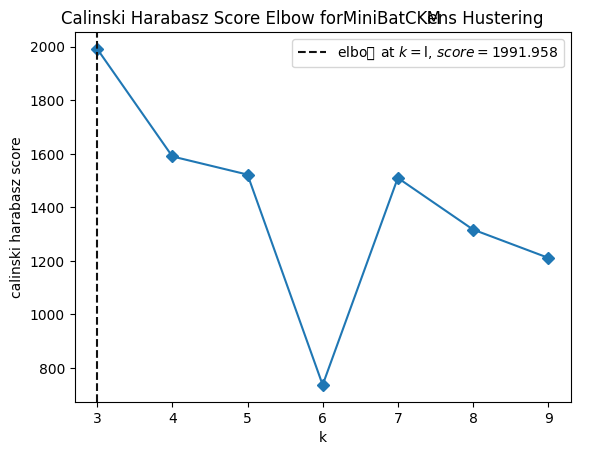

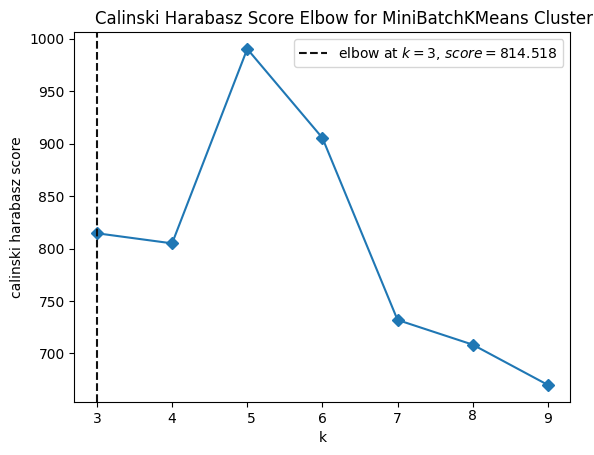

/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.8959452201933404


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


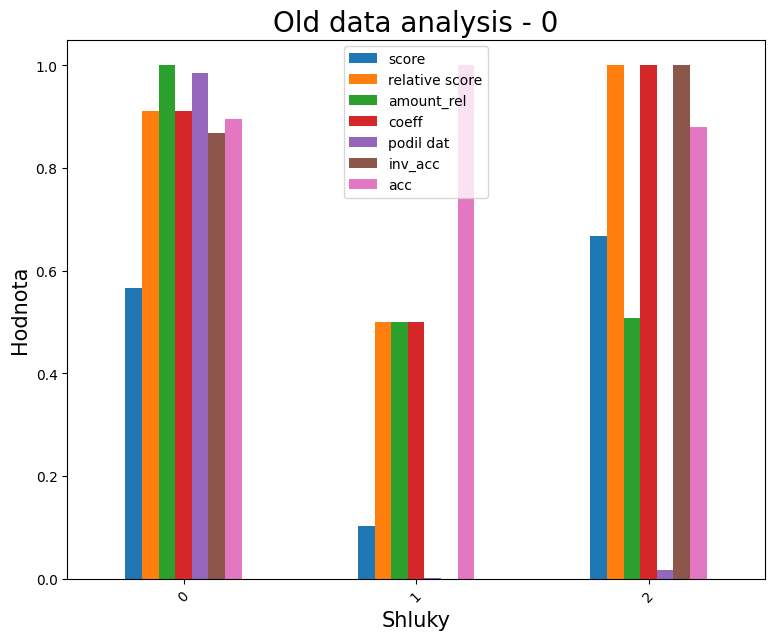

POTENTIAL AMOUNT 7447
REDUCED AMOUNT 7281
Extracted data 0  -  7282


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.9356670797191243


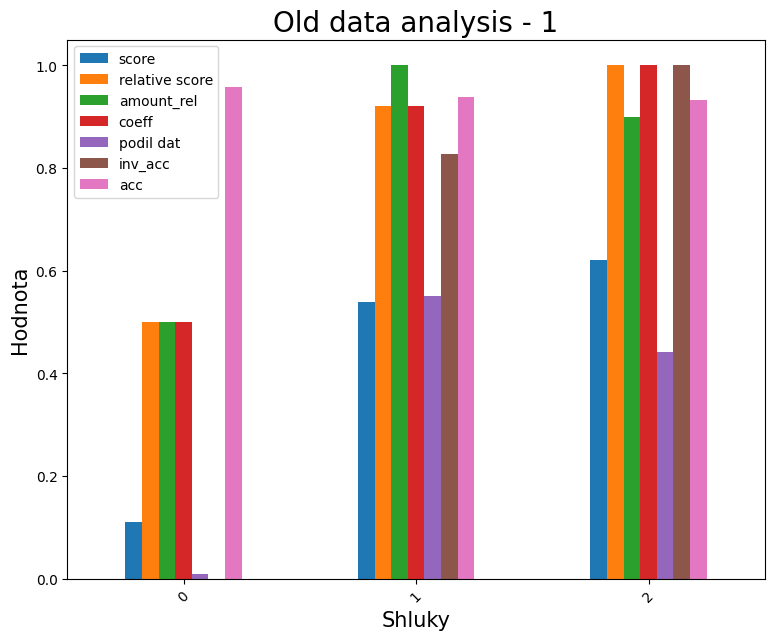

POTENTIAL AMOUNT 9214
REDUCED AMOUNT 7281
Extracted data 1  -  7282
CPU times: user 256 ms, sys: 175 ms, total: 431 ms
Wall time: 6.83 s
Old dataset balance {0: 7448, 1: 9684, 'all': 17132}


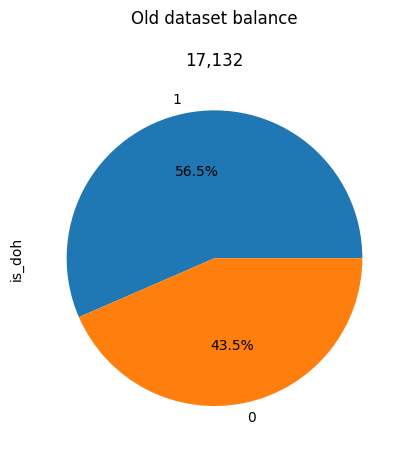

Clustered dataset balance {0: 7282, 1: 7282, 'all': 14564}


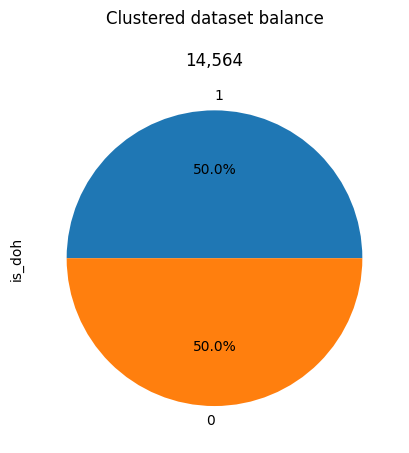

Reduction ratio 14.989493345785661


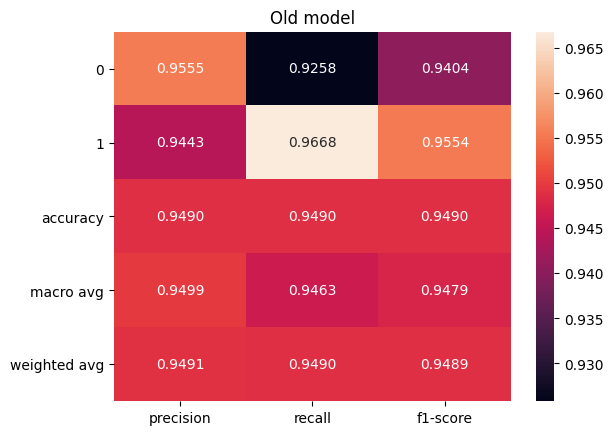

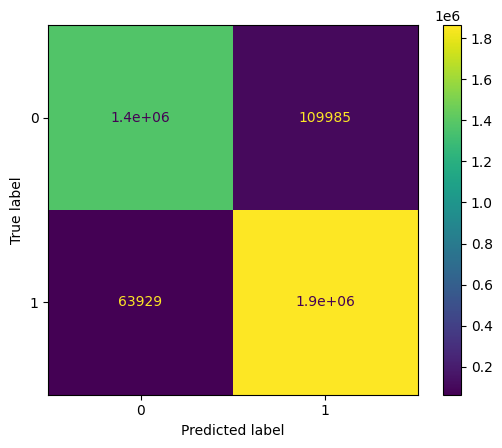

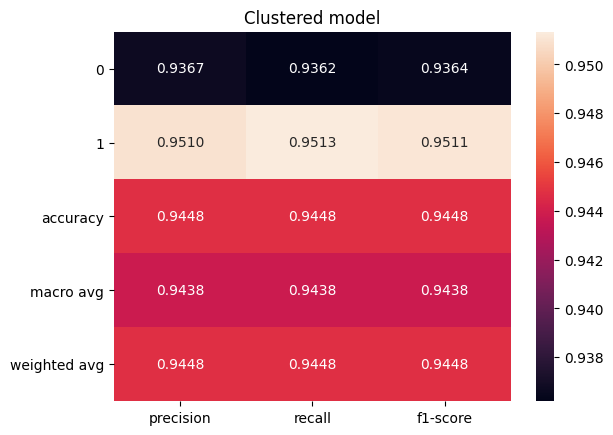

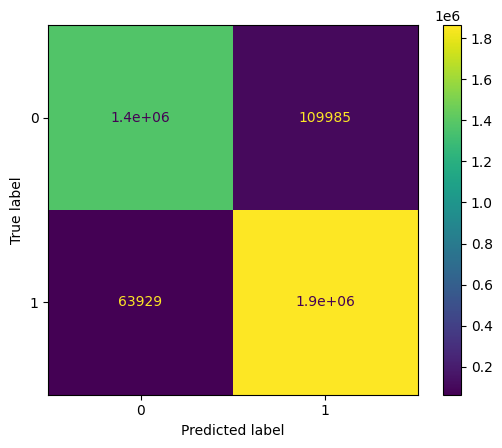

Improvement -8.084084987062132
bouldin
Old data analysis - 0 To be extracted -  7281
Old data analysis - 1 To be extracted -  7281
(7448, 24)
(9684, 24)
(7448, 21)
(9684, 21)


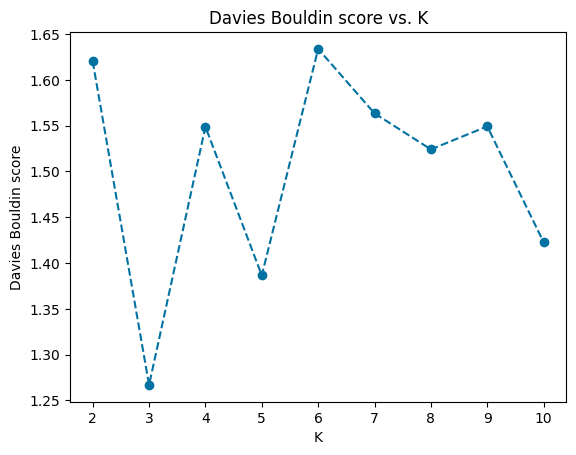

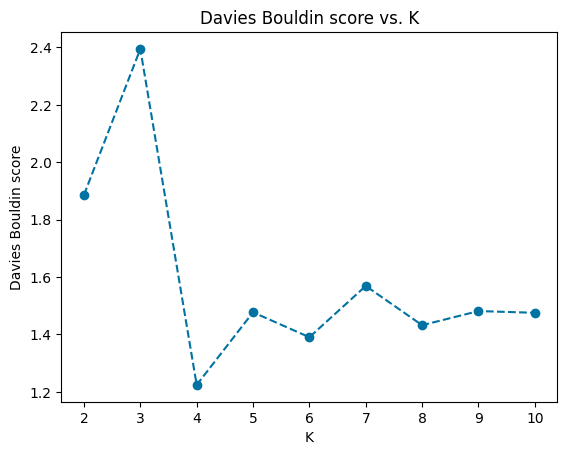

/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.8959452201933404


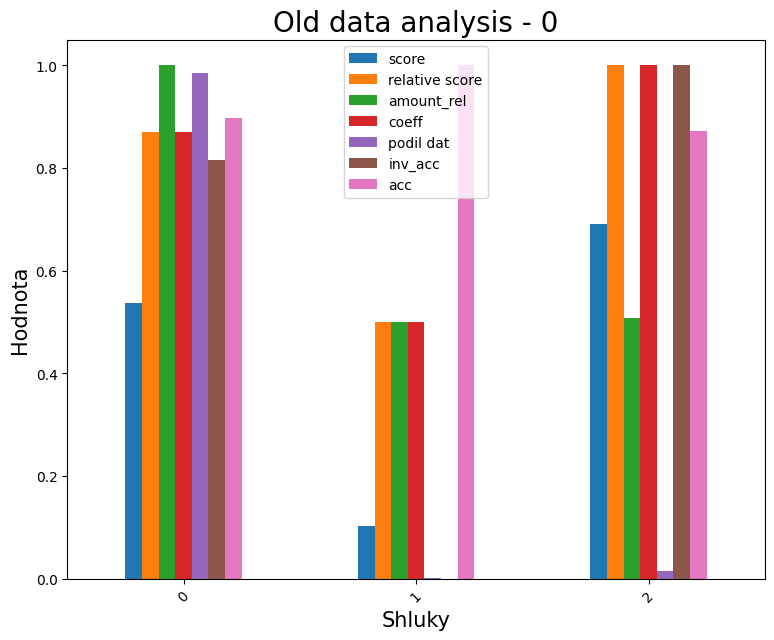

POTENTIAL AMOUNT 7447
REDUCED AMOUNT 7281
Extracted data 0  -  7282


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.9356670797191243


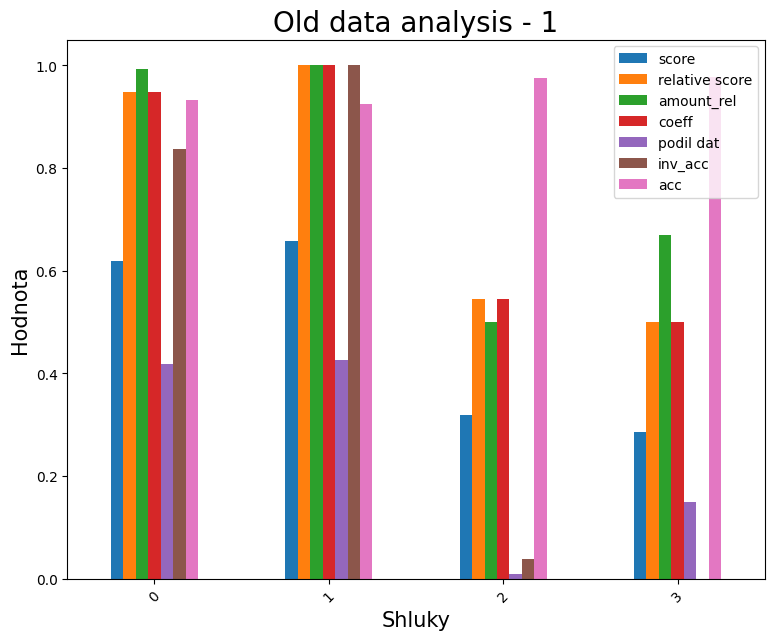

POTENTIAL AMOUNT 8718
REDUCED AMOUNT 7281
Extracted data 1  -  7281
CPU times: user 235 ms, sys: 149 ms, total: 384 ms
Wall time: 6.19 s
Old dataset balance {0: 7448, 1: 9684, 'all': 17132}


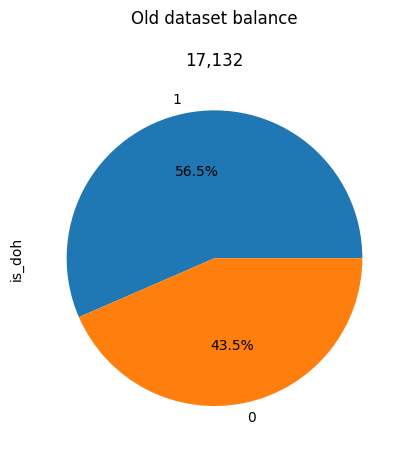

Clustered dataset balance {0: 7282, 1: 7281, 'all': 14563}


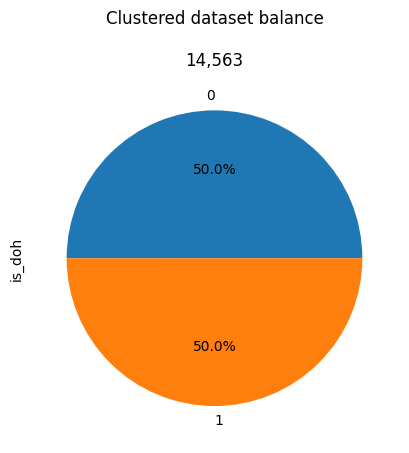

Reduction ratio 14.995330375904743


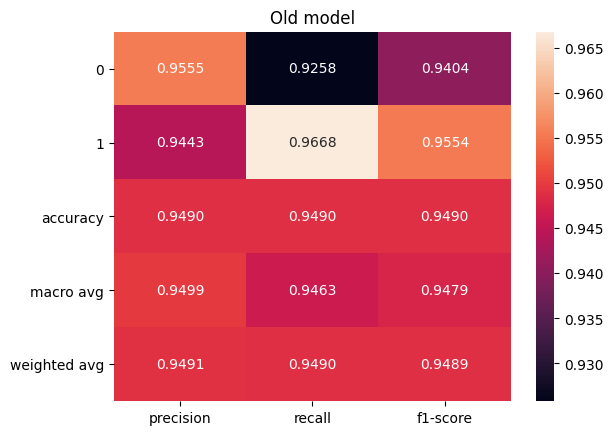

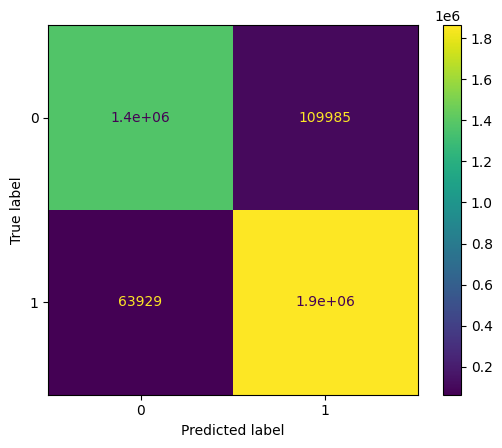

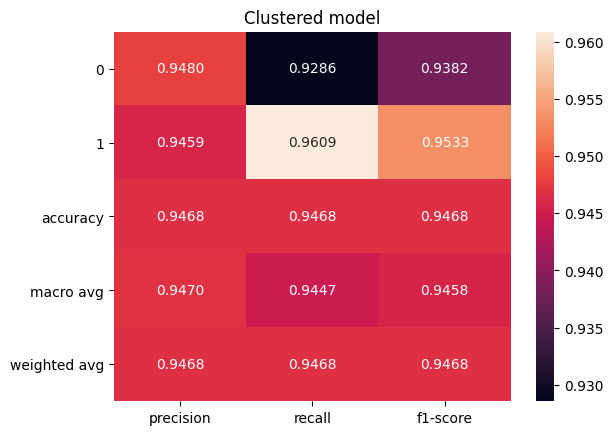

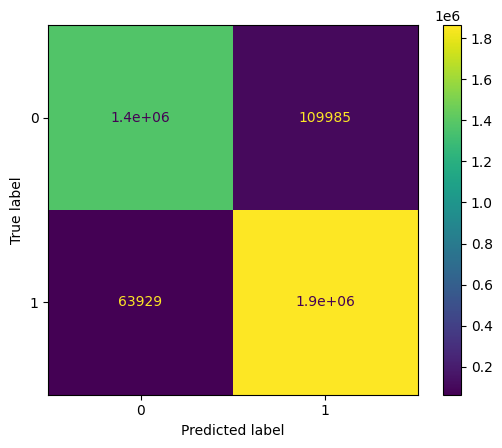

Improvement -4.170649208972973
PRE
Old data analysis - 0 To be extracted -  7281
Old data analysis - 1 To be extracted -  7281
(7448, 24)
(9684, 24)
(7448, 21)
(9684, 21)
CRIT 0.025682920097863708
SSE 163903.8237284232
CRIT 0.025372908921933085SSE
SSE  146547.41268380274213075.14364051065

PRE 0.10589387513850052 2
SSE 129847.08425972838
PRESSE  0.11395853477200409 181100.689112344263

PRE 0.1500618701077214 2
SSE 118901.40435580885
PRE 0.08429669380966066SSE 4 
179587.59979537228
PRE 0.008354961675675052 SSE3 108369.80404760622

PRE 0.08857422976003829 5
SSE 112489.06978890042
PRE -0.038011194884920496 6


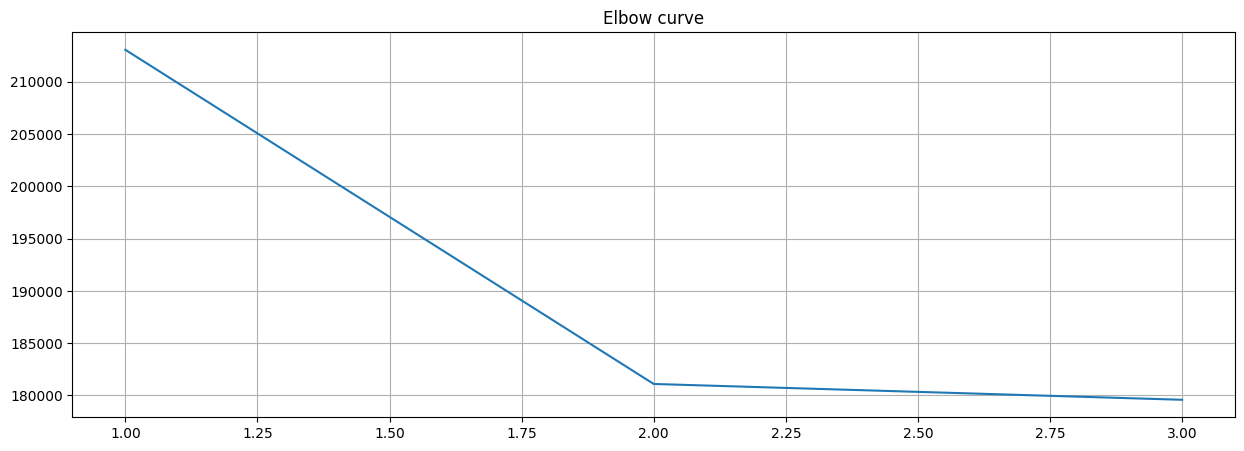

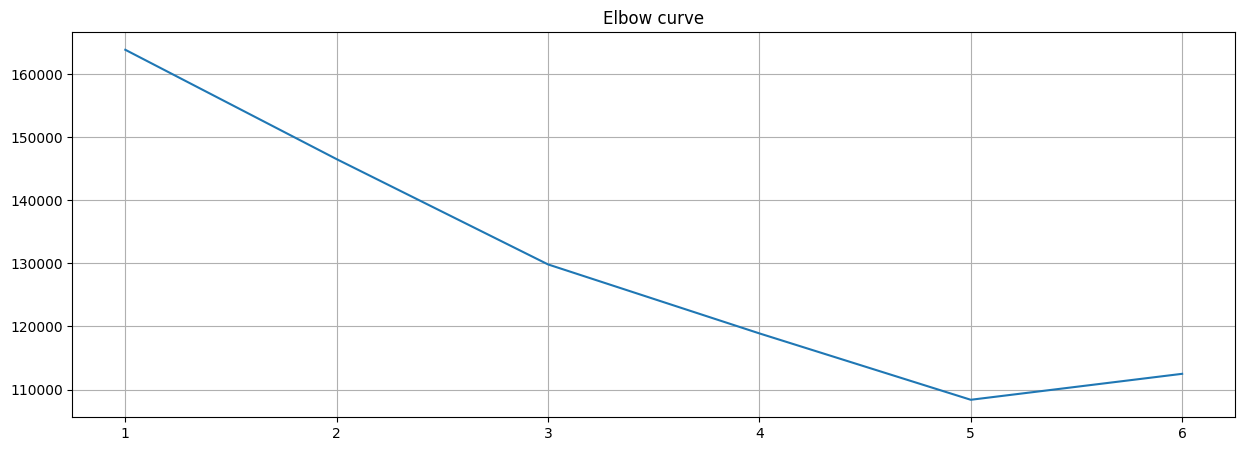

/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.9356670797191243


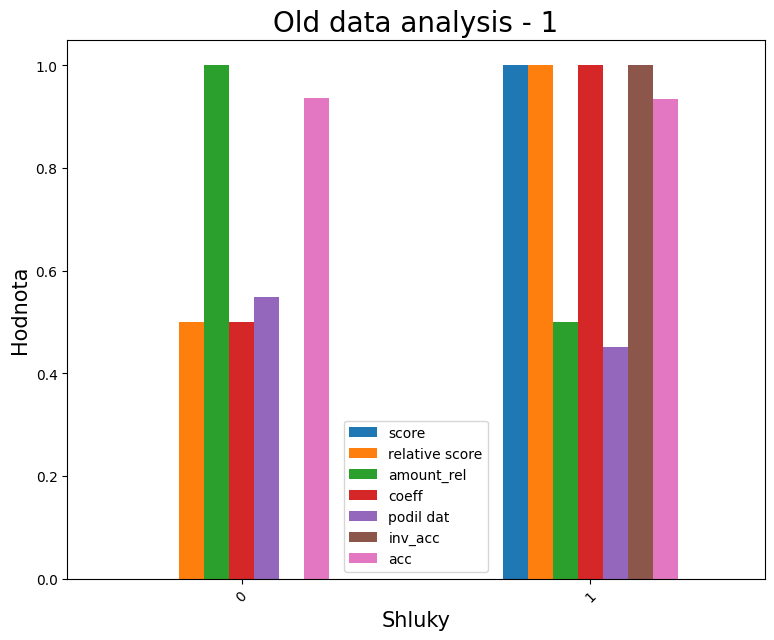

POTENTIAL AMOUNT 7426
REDUCED AMOUNT 7281
Extracted data 1  -  7282


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.8959452201933404


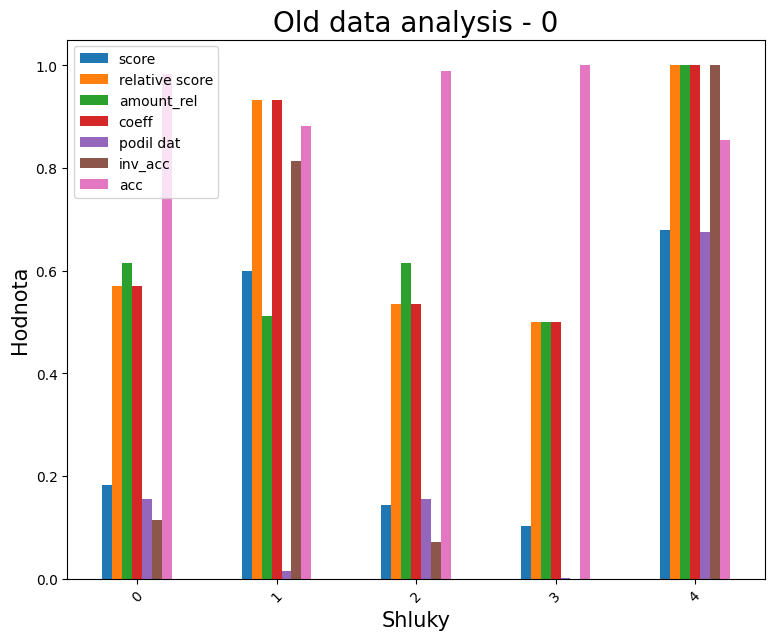

POTENTIAL AMOUNT 6748
REDUCED AMOUNT 7281
Extracted data 0  -  6749
CPU times: user 272 ms, sys: 170 ms, total: 442 ms
Wall time: 6.48 s
Old dataset balance {0: 7448, 1: 9684, 'all': 17132}


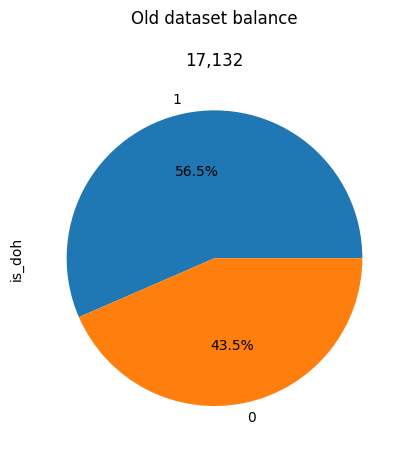

Clustered dataset balance {0: 6749, 1: 7282, 'all': 14031}


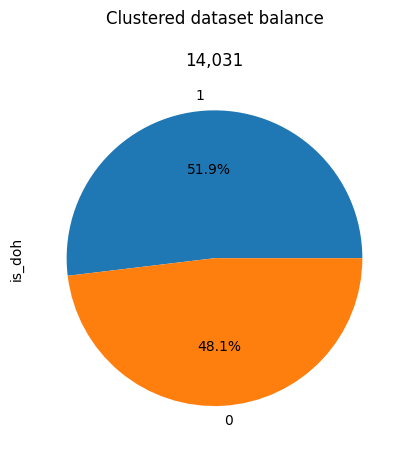

Reduction ratio 18.100630399252864


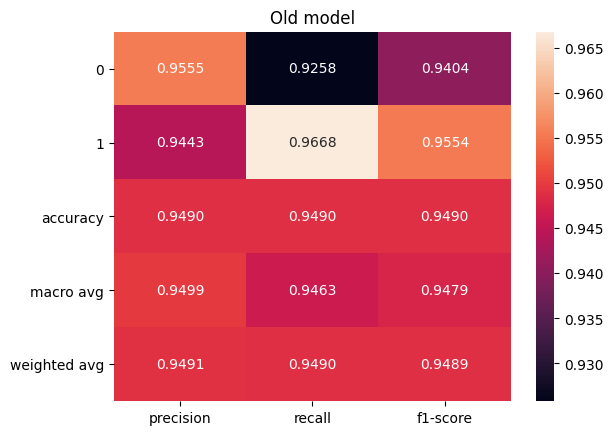

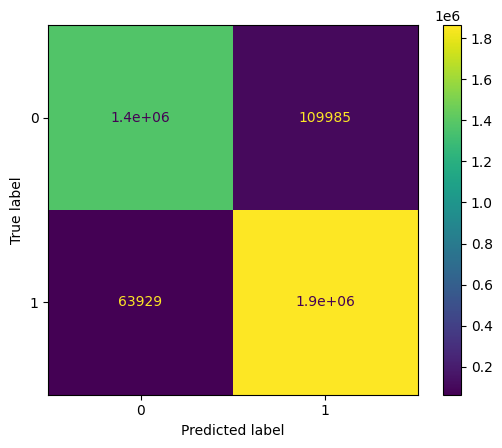

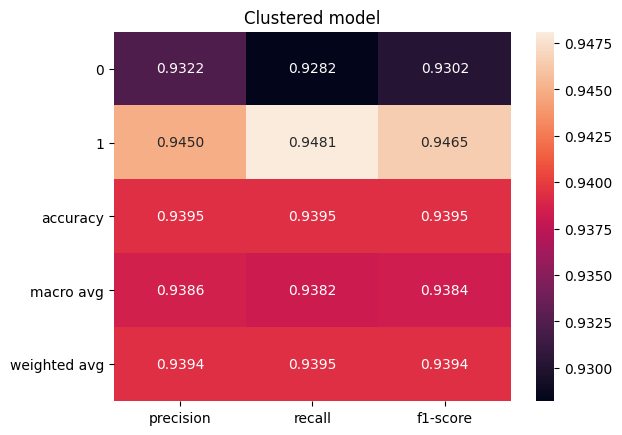

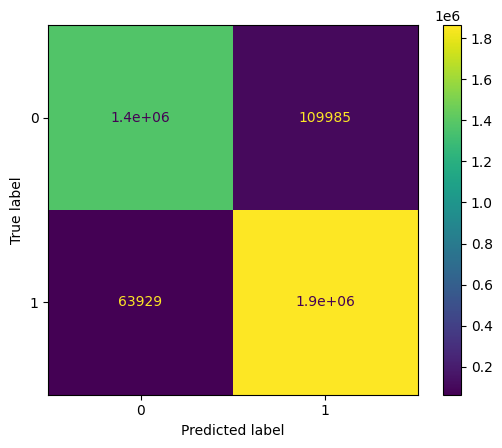

Improvement -18.487911860867463
elbow
Old data analysis - 0 To be extracted -  7281
Old data analysis - 1 To be extracted -  7281
(7448, 24)
(9684, 24)
(7448, 21)
(9684, 21)
check
check


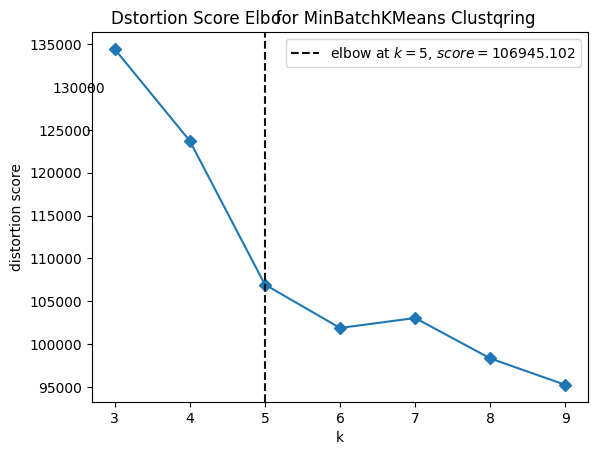

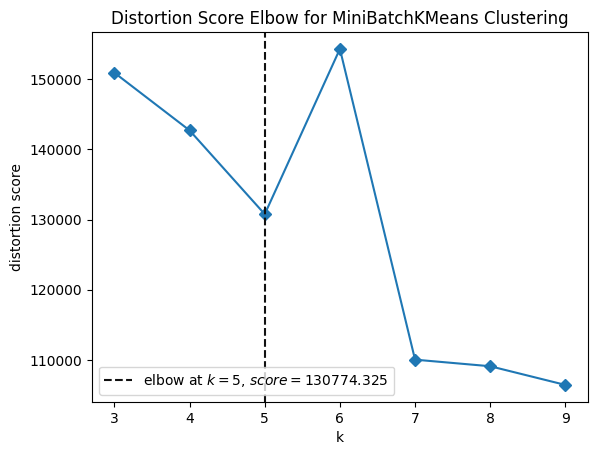

/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.8959452201933404


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.9356670797191243


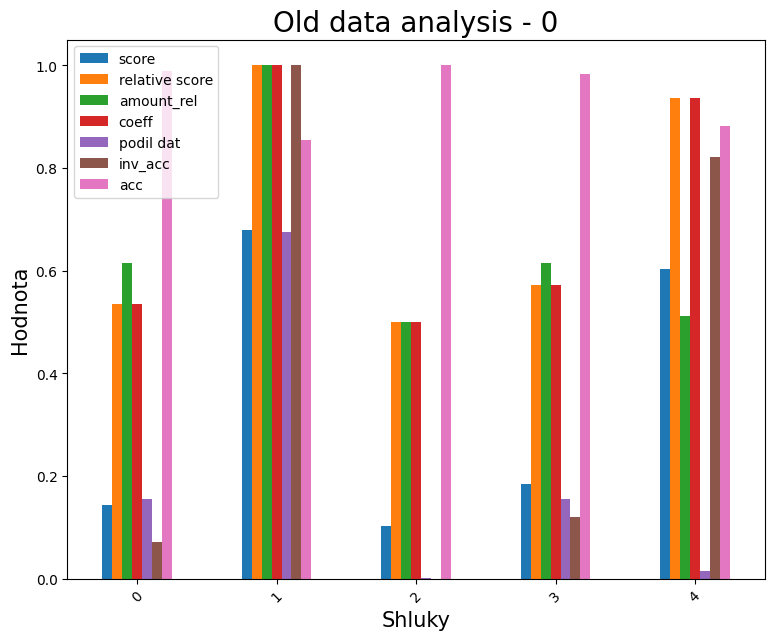

POTENTIAL AMOUNT 6750
REDUCED AMOUNT 7281
Extracted data 0  -  6751


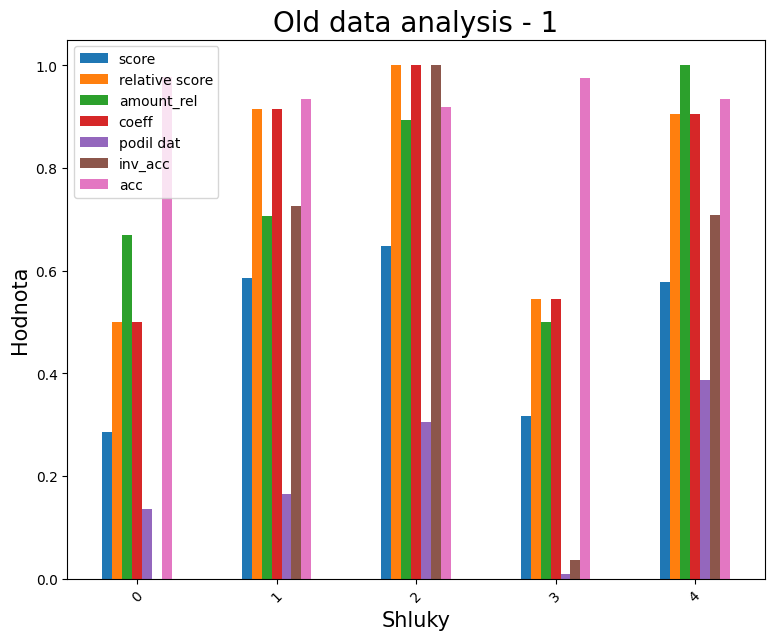

POTENTIAL AMOUNT 8495
REDUCED AMOUNT 7281
Extracted data 1  -  7282
CPU times: user 232 ms, sys: 158 ms, total: 391 ms
Wall time: 6.8 s
Old dataset balance {0: 7448, 1: 9684, 'all': 17132}


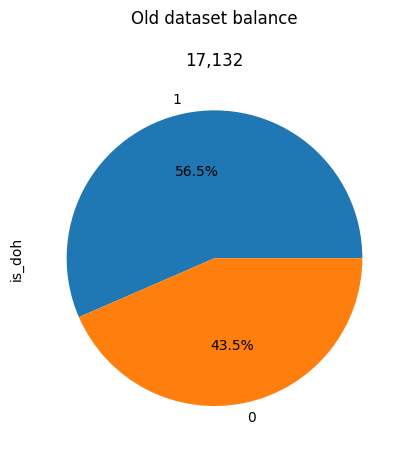

Clustered dataset balance {0: 6751, 1: 7282, 'all': 14033}


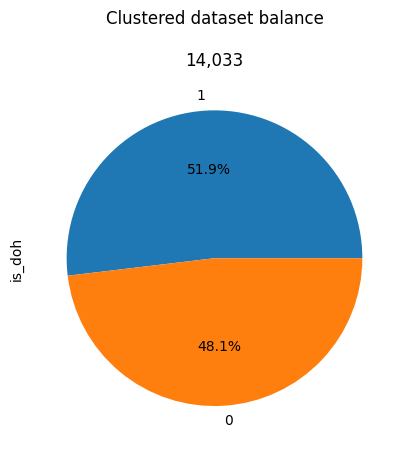

Reduction ratio 18.0889563390147


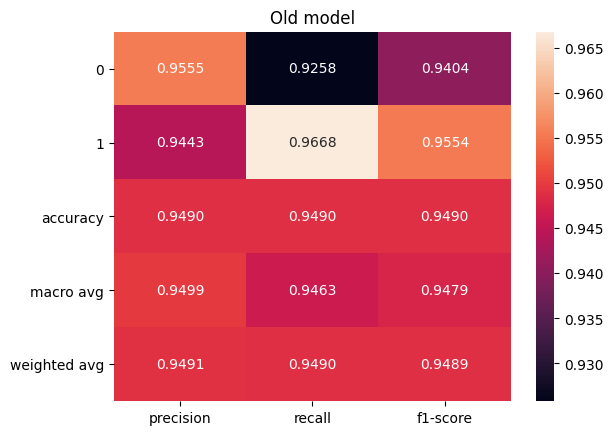

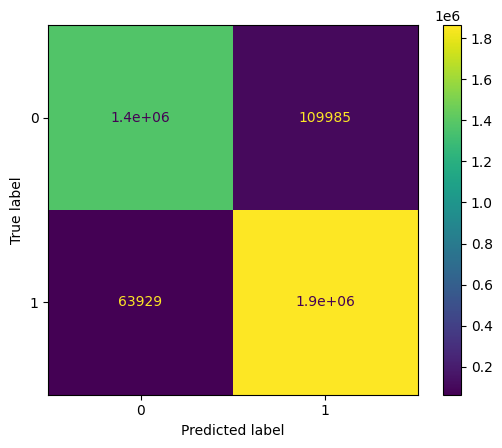

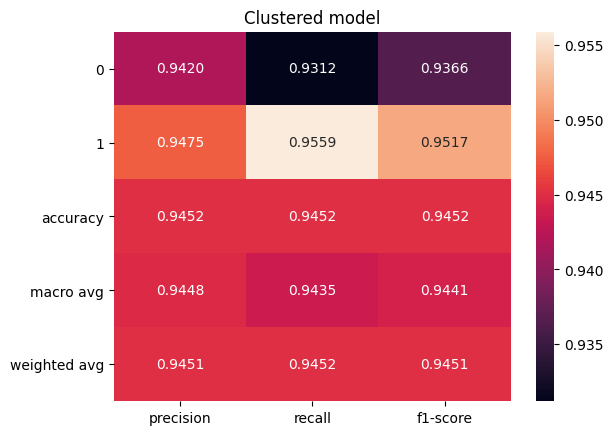

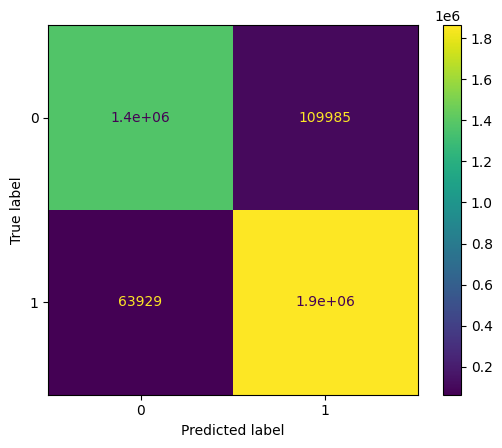

Improvement -7.371910907247979
h2o
default
Old data analysis - 0 To be extracted -  7281
Old data analysis - 1 To be extracted -  7281
Checking whether there is an H2O instance running at http://localhost:54321.Checking whether there is an H2O instance running at http://localhost:54321. connected.
 connected.


H2O_cluster_uptime:,2 hours 26 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_netmon_41iafs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.95 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


H2O_cluster_uptime:,2 hours 26 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_netmon_41iafs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,29.95 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |████████████████████████████████████████████████████████████████| (done) 100%
kmeans Model Build progress: |████████████████████████████████████████████████████| (done) 100%██████████████████████████████████████████████████| (done) 100%

kmeans prediction progress: |kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%████████████████████████████████████████████████████| (done) 100%



/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.9356670797191243


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


<Figure size 640x480 with 0 Axes>

TOTAL ACC 0.8959452201933404


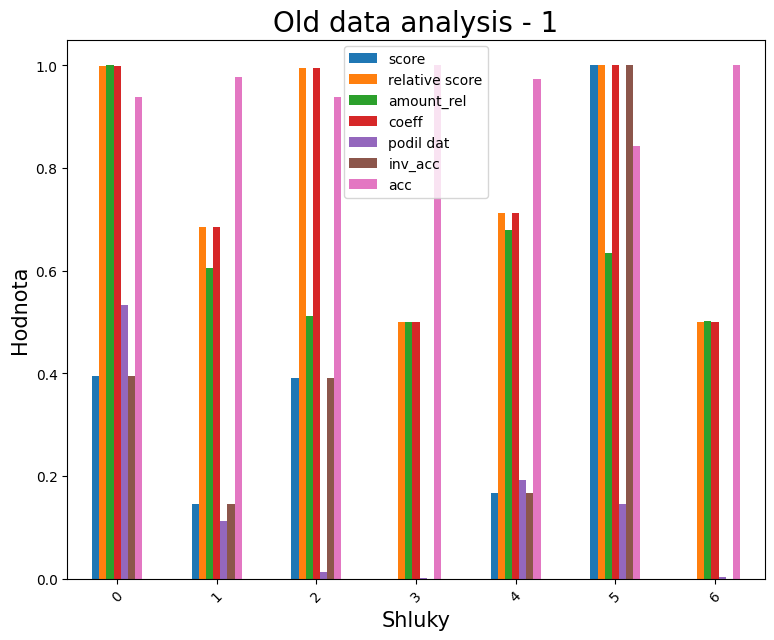

POTENTIAL AMOUNT 8772
REDUCED AMOUNT 7281
Extracted data 1  -  7281


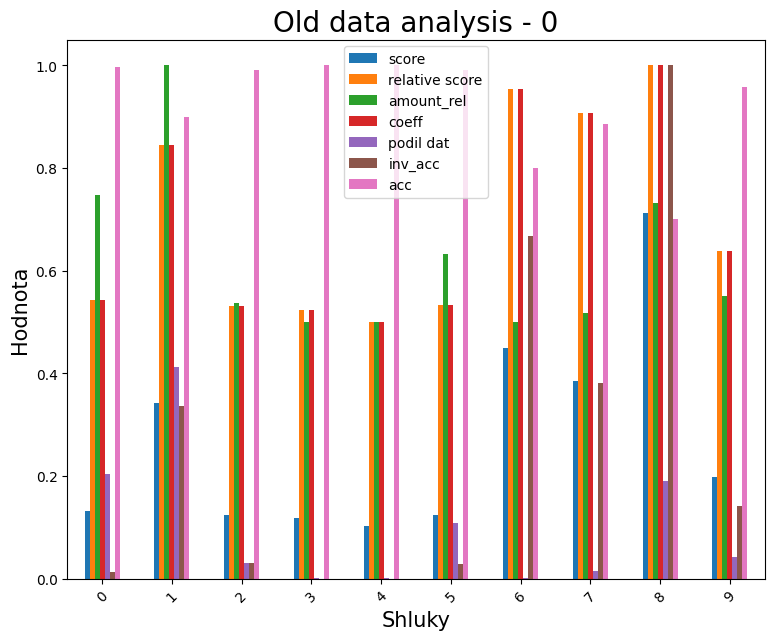

POTENTIAL AMOUNT 6825
REDUCED AMOUNT 7281
Extracted data 0  -  6827
CPU times: user 246 ms, sys: 195 ms, total: 441 ms
Wall time: 3.59 s
Old dataset balance {0: 7448, 1: 9684, 'all': 17132}


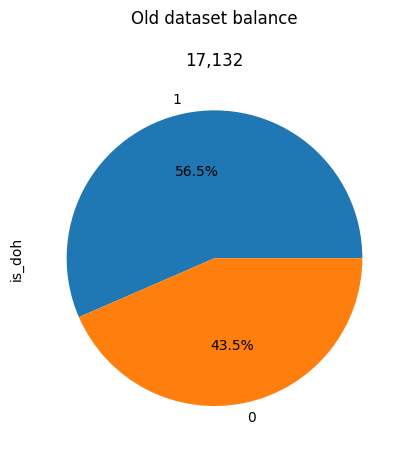

Clustered dataset balance {0: 6827, 1: 7281, 'all': 14108}


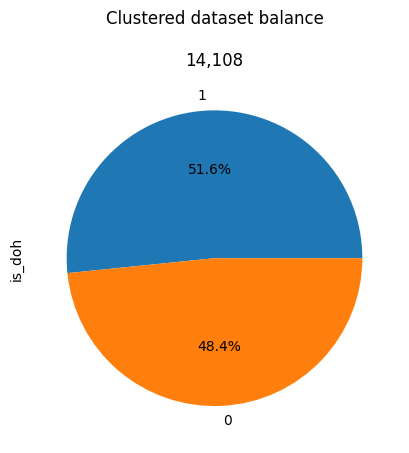

Reduction ratio 17.651179080084063


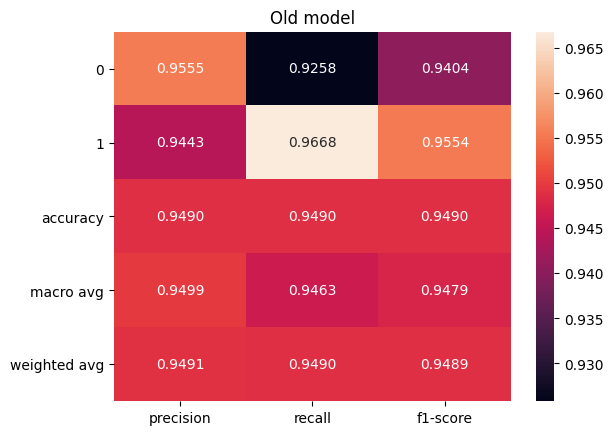

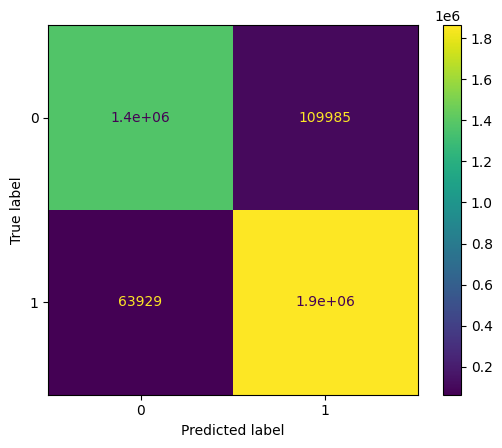

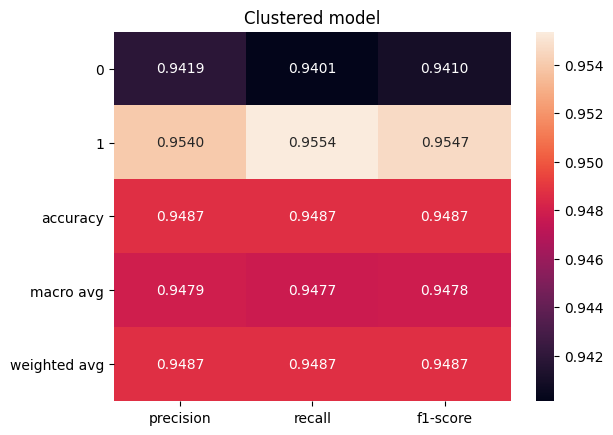

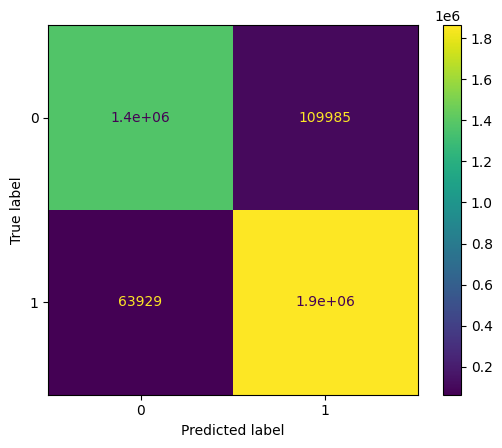

Improvement -0.3007823261117808


In [26]:


for alg in ['kmeans','h2o']:#,"h2o"]:#h2o,aglomerative
    print(alg)
    if alg== 'h2o':
        k_methods=['default']
    else:
        k_methods=['calinski_harabasz','bouldin','PRE','elbow']#,'calinski_harabasz','silhouette','elbow','bouldin','PRE']:
    for metric in k_methods:
        print(metric)
        for red in [0.85]:#[0.8,0.7,0.6,0.5,0.4]:#0.3,0.2,0.1,0.05
        
            input_vector,jobs,reduction=get_params(red)
            %time results=Parallel(n_jobs=jobs,backend="multiprocessing")([delayed(modification_one)(label=i[0],data=i[1],clf=i[2],undersample=i[3],metric=metric,alg=alg,desc=i[4]) for i in input_vector])
            
            old_data.newdata=pd.concat(results)
            #print(old_data.newdata)

            clustered_result=old_data.compare_models(clfs['old'],clfs['clustered'],test_data)
            tmp=old_data.prepare_model_result(clustered_result,text+" "+str(reduction),use_case,alg+'_'+metric)
            framework_result=pd.concat([framework_result,tmp])

        # balance=old_data.class_balance(old_data.newdata[old_data.label].reset_index(drop=True))
        # sampling_ratio=balance[1]/balance[0]
        # balance_dict={0:balance[0],1:balance[1]}
        # old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))
        # old_data.set_newdata()
        # new_data.set_data(pd.concat([X_train_new,y_train_new],axis=1))
        # new_data.set_newdata()


In [35]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support_0,Support_1
0,DOH,imbl reducing 0.9,kmeans_calinski_harabasz,0.944036,0.944006,0.944036,0.944009,-9.548716,7079,7709
0,DOH,imbl reducing 0.9,kmeans_bouldin,0.939378,0.939344,0.939378,0.939329,-18.704482,7165,7709
0,DOH,imbl reducing 0.9,kmeans_PRE,0.934973,0.934938,0.934973,0.934948,-27.277431,7273,7709
0,DOH,imbl reducing 0.9,kmeans_elbow,0.934973,0.934938,0.934973,0.934948,-27.277431,7273,7709
0,DOH,imbl reducing 0.9,h2o_default,0.929740,0.929692,0.929740,0.929698,-37.549027,6957,7710
0,DOH,imbl reducing 0.85,kmeans_calinski_harabasz,0.941586,0.941600,0.941586,0.941507,-14.443921,7282,7282
0,DOH,imbl reducing 0.85,kmeans_bouldin,0.941586,0.941600,0.941586,0.941507,-14.443921,7282,7282
0,DOH,imbl reducing 0.85,kmeans_PRE,0.945227,0.945198,0.945227,0.945193,-7.232939,6749,7282
0,DOH,imbl reducing 0.85,kmeans_elbow,0.929920,0.929873,0.929920,0.929879,-37.193982,6751,7282
0,DOH,imbl reducing 0.85,h2o_default,0.937012,0.936975,0.937012,0.936982,-23.296462,6827,7281


In [33]:
framework_result.to_csv(f"xsetin00/{use_case}/incremental_imbl0.8_comparation.csv",mode='a',index=False)

# Comparation

Old data analysis - 0 To be extracted -  7281
Old data analysis - 1 To be extracted -  7281
{0: 7281, 1: 7281}
cluster centroids


/usr/local/lib/python3.6/dist-packages/imblearn/under_sampling/_prototype_generation/_cluster_centroids.py:121: FutureWarning: 'n_jobs' was deprecated in 0.7 and will be removed in 0.9
  FutureWarning


CPU times: user 29min 4s, sys: 22min 12s, total: 51min 17s
Wall time: 6min 59s
Old dataset balance {0: 7448, 1: 9684, 'all': 17132}


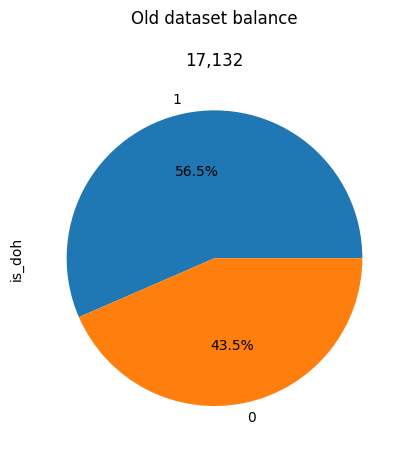

Random sampled dataset balance {0: 7281, 1: 7281, 'all': 14562}


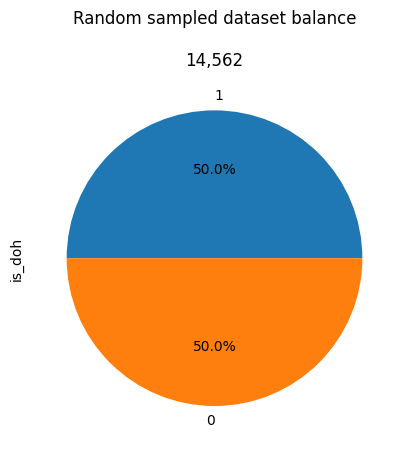

Reduction ratio 15.001167406023825


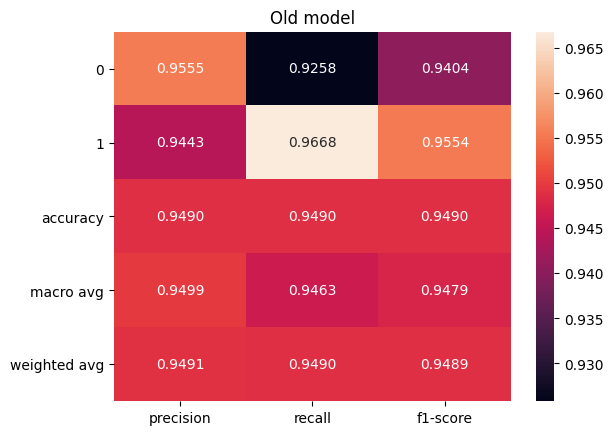

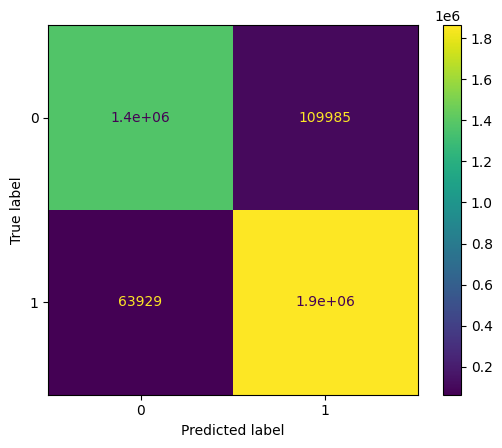

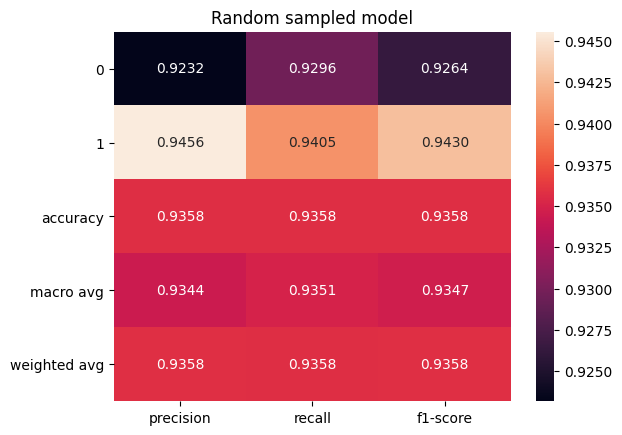

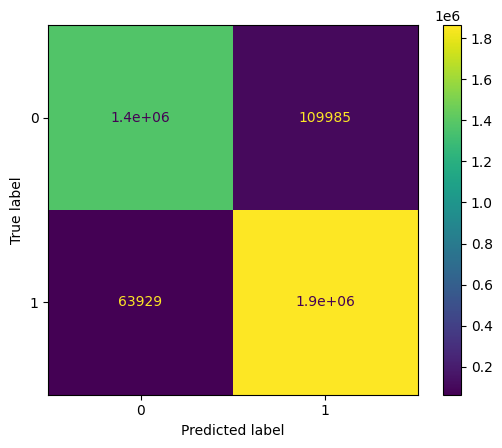

Improvement -25.633887110570523
  Dataset                  Method                    Metric       Acc  \
0     DOH       imbl reducing 0.9  kmeans_calinski_harabasz  0.944036   
0     DOH       imbl reducing 0.9            kmeans_bouldin  0.939378   
0     DOH       imbl reducing 0.9                kmeans_PRE  0.934973   
0     DOH       imbl reducing 0.9              kmeans_elbow  0.934973   
0     DOH       imbl reducing 0.9               h2o_default  0.929740   
0     DOH      imbl reducing 0.85  kmeans_calinski_harabasz  0.941586   
0     DOH      imbl reducing 0.85            kmeans_bouldin  0.941586   
0     DOH      imbl reducing 0.85                kmeans_PRE  0.945227   
0     DOH      imbl reducing 0.85              kmeans_elbow  0.929920   
0     DOH      imbl reducing 0.85               h2o_default  0.937012   
0     DOH      imbl reducing 0.85  kmeans_calinski_harabasz  0.944759   
0     DOH      imbl reducing 0.85            kmeans_bouldin  0.946825   
0     DOH      imbl

In [34]:
for reduction in [0.85]:#,0.7,0.6,0.5,0.4]:#[1,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]:
  vec,_,red=get_params(reduction)
  if merging:
    balance_dict={0:vec[0][3]+vec[2][3],1:vec[1][3]+vec[3][3]}
  else:
    balance_dict={0:vec[0][3],1:vec[1][3]}
  print(balance_dict)
  imbl=[#(NearMiss(sampling_strategy=balance_dict,version=1,n_jobs=-1),"near miss1"),###########
        #(NearMiss(sampling_strategy=balance_dict,version=2,n_jobs=-1),"near miss2"),############
        #(NearMiss(sampling_strategy=balance_dict,version=3,n_jobs=-1),"near miss3"),
        #(CondensedNearestNeighbour(random_state=42,sampling_strategy='all',n_jobs=-1),"condensed_NN"),
        #(EditedNearestNeighbours(),"edited_NN"),
        #(RepeatedEditedNearestNeighbours(sampling_strategy='all',n_jobs=-1),"rep_edited__NN"),
        #(InstanceHardnessThreshold(sampling_strategy=balance_dict,random_state=42, estimator=LogisticRegression(solver='lbfgs', max_iter=200)),"inst_hard_tresh"),########
        #(NeighbourhoodCleaningRule(sampling_strategy='all',n_jobs=-1),"neigh_clean_rule"),
        #(OneSidedSelection(sampling_strategy='all',n_jobs=-1,random_state=42),"one_sided_sel"),
        #(RandomUnderSampler(sampling_strategy=balance_dict),"random sampler"),#ranmagic random_state=1
        #(TomekLinks(sampling_strategy='all',n_jobs=-1),"tomek_links"),
        #(AllKNN(sampling_strategy='all',n_jobs=-1),"allKNN"),
        (ClusterCentroids(sampling_strategy=balance_dict,n_jobs=-1),"cluster centroids"),#########
        #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
        ]

  if merging:
    backup=old_data.csv_data
    old_data.csv_data=pd.concat([old_data.csv_data,new_data.csv_data],axis=0)
  for sampler in imbl:
    print(sampler[1])
    %time old_data.apply_imbalanced_lib(sampler[0])
    imbl_result=old_data.compare_models(clfs['old'],clfs['compare'],test_data,"Random sampled")
    tmp=old_data.prepare_model_result(imbl_result,sampler[1]+" "+str(red),use_case,sampler[1])
    framework_result=pd.concat([framework_result,tmp])

  #framework_result.reset_index(inplace=True,drop=True)
  print(framework_result)
  if merging:
    old_data.csv_data=backup

### Sampled union data

In [ ]:
for label in [(0,225424),(1,38121)]:
    old_data.set_class(label[0])
    reduced_X_train_old, reduced_size, reduced_y_train_old, _ = train_test_split(old_data.X, old_data.y, train_size=label[1]*0.9/old_data.y.shape[0], random_state=42, shuffle=True)#, stratify=y_train_old)
    print(reduced_size.shape)
    new_data.set_class(label[0])
    reduced_X_train_new, reduced_size, reduced_y_train_new, _ = train_test_split(new_data.get_features(new_data.synt_data), new_data.get_label(new_data.synt_data), train_size=label[1]*0.1/new_data.get_label(new_data.synt_data).shape[0], random_state=42, shuffle=True)
    print(reduced_X_train_new.shape)
    if label[0]==0:
        X_train_union=pd.concat([reduced_X_train_old,reduced_X_train_new])
        y_train_union=pd.concat([reduced_y_train_old,reduced_y_train_new])
    else:
        X_train_union=pd.concat([X_train_union,reduced_X_train_old,reduced_X_train_new])
        y_train_union=pd.concat([y_train_union,reduced_y_train_old,reduced_y_train_new])
# size_ratio=X_train_old.shape[0]/X_train_union.shape[0]
# union_X_train, _, union_y_train, _ = train_test_split(X_train_union, y_train_union, train_size=size_ratio, random_state=42, shuffle=True, stratify=y_train_union)

print(old_data.class_balance(y_train_union))

(22543, 24)
(22542, 24)
(3813, 24)
(3812, 24)
{0: 225423, 1: 38120, 'all': 263543}


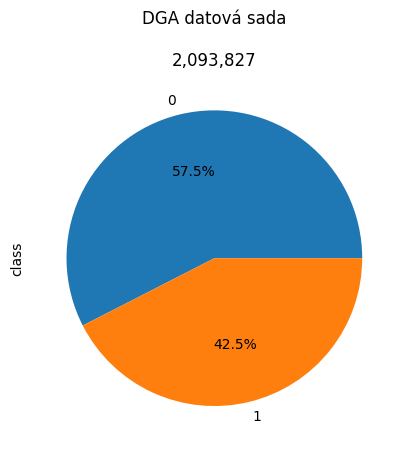

In [80]:
old_data.plot_balance("DGA datová sada")